# This notebook was deprecated due to it being conjoined with notebook 7b

## AIM: Train Graph Convulation Networks (GCNs) as multiclass classification models for predicting the psychiatric diagnosis based on EEG features

GraphLambda with & without edge attributes for predicting psychiatric diagnosis with statistical features of the power per frequency band per channel group (frontal, central, parietal, occipital) and connectivity features per frequency band per channel group (l/m/r; frontal, central, ). Statistical features are calculated with EC data, EO data and a with the ratio between EC divided by EO.

Have to use features before feature selection, to maintain even dimensions for each graph. Stat features are standardized before training. Models are tuned using multi-objective Optuna, maximizing val f1 and minimizing val loss

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import optuna

import lightning.pytorch as pl
import torch
import torch_geometric
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d
from torch_geometric.nn import  GCNConv, global_add_pool,GATConv,GINConv, GATv2Conv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx, to_networkx
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_intermediate_values
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_rank
from optuna.visualization.matplotlib import plot_slice
from optuna.visualization.matplotlib import plot_timeline

### Load data & features

In [2]:
import pickle
def load_file(file):
    with open(file, 'rb') as handle:
        return pickle.load(handle)

In [3]:
# import stat & conn features without feature selection
df_stat_conn_features = pd.read_pickle('df_stat_conn_features.pkl')
df_stat_conn_features = df_stat_conn_features.dropna(subset=['diagnosis'])

# label encode diagnosis
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df_stat_conn_features['diagnosis'])
df_stat_conn_features['diagnosis'] = le.transform(df_stat_conn_features['diagnosis'])

print(df_stat_conn_features.shape)
df_stat_conn_features.sample(3)

(2700, 1218)


ID  diagnosis  epoch  EO_l_frontal_delta_std  \
1558  sub-88046393          0     11                0.100209   
1524  sub-88045809          2      1                0.036981   
1407  sub-88041893          1      4                0.087542   

      EO_l_frontal_delta_mean  EO_l_frontal_delta_median  \
1558                 0.104650                   0.104650   
1524                 0.051764                   0.051764   
1407                 0.094826                   0.094826   

      EO_l_frontal_delta_skew  EO_l_frontal_delta_kurt  \
1558                 2.333986                 6.965741   
1524                 1.600458                 3.599735   
1407                 3.203591                13.128562   

      EO_l_frontal_theta_std  EO_l_frontal_theta_mean  ...  \
1558                0.033885                 0.066845  ...   
1524                0.063787                 0.069824  ...   
1407                0.035199                 0.061462  ...   

      ratio_gamma_m_central-r_central  ratio_gamma_m_central-l_posterior  \
1558                         0.971627                           0.984254   
1524                         1.030975                           1.051786   
1407                         1.000059                           1.003650   

      ratio_gamma_m_central-m_posterior  ratio_gamma_m_central-r_posterior  \
1558                           0.979909                           0.967063   
1524                           1.030355                           1.023867   
1407                           0.994222                           0.990820   

      ratio_gamma_r_central-l_posterior  ratio_gamma_r_central-m_posterior  \
1558                           0.971914                           0.974441   
1524                           1.033015                           1.021508   
1407                           0.990227                           0.991453   

      ratio_gamma_r_central-r_posterior  ratio_gamma_l_posterior-m_posterior  \
1558                           0.983801                             0.996058   
1524                           1.006698                             1.029710   
1407                           1.014238                             0.995607   

      ratio_gamma_l_posterior-r_posterior  ratio_gamma_m_posterior-r_posterior  
1558                             1.007662                             0.999884  
1524                             1.035802                             1.029482  
1407                             0.972756                             0.987664  

[3 rows x 1218 columns]

In [4]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_stat_conn_features_ec = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EO') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_eo = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_ratio = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('EO'))]]
print(df_stat_conn_features_ratio.shape)
print(df_stat_conn_features_ec.shape)
print(df_stat_conn_features_eo.shape)

(2700, 408)
(2700, 408)
(2700, 408)


In [5]:
synchrony_feature_dict = load_file('synchrony_feature_dict.pkl')
subjects_ec_syncro_matrices = synchrony_feature_dict['EC_syncro']
subjects_eo_syncro_matrices = synchrony_feature_dict['EO_syncro']
subjects_ec_ids = synchrony_feature_dict['EC_IDs']
subjects_eo_ids = synchrony_feature_dict['EO_IDs']
print(len(subjects_ec_syncro_matrices), len(subjects_eo_syncro_matrices))
print(len(subjects_ec_ids), len(subjects_eo_ids))
print(subjects_ec_syncro_matrices[0].shape)
print(subjects_ec_ids[0])

224 225
224 225
(12, 5, 9, 9)
sub-87964717


In [6]:
# compute ratio [EC/EO] synchrony matrices

# Convert the lists to sets
subjects_ec_ids_set = set(subjects_ec_ids)
subjects_eo_ids_set = set(subjects_eo_ids)

# find the missing IDs to make sure ratio is computed within the same participant
missing_ids = subjects_eo_ids_set - subjects_ec_ids_set
missing_ids_indices = [subjects_eo_ids.index(id) for id in missing_ids]

# remove missing IDs from EO
ratio_subjects_eo_syncro_matrices = [matrix for i, matrix in enumerate(subjects_eo_syncro_matrices) if i not in missing_ids_indices]
assert len(ratio_subjects_eo_syncro_matrices) == len(subjects_ec_syncro_matrices)

# compute ratio
subjects_ratio_syncro_matrices = []
for i in range(len(subjects_ec_syncro_matrices)):
    ratio_matrix = subjects_ec_syncro_matrices[i] / ratio_subjects_eo_syncro_matrices[i]
    subjects_ratio_syncro_matrices.append(ratio_matrix)
subjects_ratio_ids = subjects_ec_ids
print(len(subjects_ratio_syncro_matrices), len(subjects_ratio_ids))

224 224


/tmp/ipykernel_190012/1473655494.py:18: RuntimeWarning: invalid value encountered in divide
  ratio_matrix = subjects_ec_syncro_matrices[i] / ratio_subjects_eo_syncro_matrices[i]


In [7]:
# define function to store features in PyTorch Geometric Data objects
import networkx as nx
from joblib import Parallel, delayed # for parallel processing
from tqdm import tqdm
def process_subject(syncros, subject_id, df_features):
    graph_dataset = []
    y_list = []

    # obtain statistical features for subject
    subject_stat_features = df_features[df_features['ID'] == subject_id]
    stat_columns = ['epoch', 'mean', 'median', 'std', 'kurt', 'skew'] # select statistical features
    pattern = '|'.join(stat_columns)  # create a pattern string
    subject_stat_features = subject_stat_features[subject_stat_features.columns[subject_stat_features.columns.str.contains(pattern)]]
    
    for epoch, syncro_matrices in enumerate(syncros):
        num_edges = int((syncro_matrices.shape[1] * (syncro_matrices.shape[2] - 1)) / 2)
        bands = syncro_matrices.shape[0]
        edge_attrs = np.zeros((num_edges, bands)) # create empty array to store edge weights for each frequency band

        for i, syncro_matrix in enumerate(syncro_matrices):
            # print(f'{syncro_matrix.shape = }')
            syncro_graph = nx.from_numpy_array(syncro_matrix)
            # print(f'{syncro_graph = }')
            edge_list = nx.to_pandas_edgelist(syncro_graph)
            edge_list = edge_list.dropna(axis=0)
            # print(f'{edge_list = }')
            edge_index = edge_list.iloc[:,0:2].values.T # shape (2, num_edges), edge_index stays the same for all bands right?
            # print(f'{edge_index = }')
            edge_attr = edge_list.iloc[:,2].values#.reshape(-1,1)
            edge_attrs[:,i] = edge_attr

        y = df_stat_conn_features_ec[df_stat_conn_features_ec['ID'] == subject_id]['diagnosis'].values[0]
        
        # store statistical features for subject
        ch_groups = ['l_frontal', 'm_frontal', 'r_frontal', 'l_central', 'm_central', 'r_central', 'l_posterior', 'm_posterior', 'r_posterior']
        bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
        x = np.zeros((len(ch_groups), len(bands) * (len(stat_columns)-1))) # -1 because of epochs column in stat_columns
        # print(x.shape)
        for num, ch_group in enumerate(ch_groups):
            x[num] = subject_stat_features[subject_stat_features['epoch'] == (epoch + 1)][subject_stat_features.columns[subject_stat_features.columns.str.contains(ch_group)]].values[0]
            

        data = Data(x=torch.tensor(x, dtype=torch.float),                     # Node features [num_nodes, num_node_features]
                    edge_index=torch.tensor(edge_index, dtype=torch.long),    # Adjacency matrix [2, num_edges]
                    edge_attr=torch.tensor(edge_attrs,dtype=torch.float),  # Edge features [num_edges, num_edge_features]
                    y=torch.tensor([y], dtype=torch.long))                    # Target/Label (it should be a list) --> torch.long for classification, torch.float for regression
        graph_dataset.append(data)
        y_list.append(y)

    return graph_dataset, y_list

In [8]:
# retrieve and store data for EC features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_stat_conn_features_ec) for syncros, subject_id in tqdm(zip(subjects_ec_syncro_matrices, subjects_ec_ids), total=len(subjects_ec_syncro_matrices)))

ec_graph_dataset = []
ec_y_list = []
for result in results:
    ec_graph_dataset.extend(result[0])
    ec_y_list.extend(result[1])
    
assert len(ec_graph_dataset) == len(ec_y_list)

print(f'{ec_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{ec_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{ec_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(ec_graph_dataset) = }, subjects: {len(subjects_ec_syncro_matrices)}, epochs: {len(subjects_ec_syncro_matrices[0])}')
print(f'{ec_graph_dataset[0] = }')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:05<00:00, 39.34it/s]


ec_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
ec_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
ec_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(ec_graph_dataset) = 2688, subjects: 224, epochs: 12
ec_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


In [9]:
# retrieve and store data for EO features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_stat_conn_features_eo) for syncros, subject_id in tqdm(zip(subjects_eo_syncro_matrices, subjects_eo_ids), total=len(subjects_eo_syncro_matrices)))

eo_graph_dataset = []
eo_y_list = []
for result in results:
    eo_graph_dataset.extend(result[0])
    eo_y_list.extend(result[1])
    
assert len(eo_graph_dataset) == len(eo_y_list)

print(f'{eo_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{eo_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{eo_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(eo_graph_dataset) = }, subjects: {len(subjects_eo_syncro_matrices)}, epochs: {len(subjects_eo_syncro_matrices[0])}')
print(f'{eo_graph_dataset[0] = }')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:02<00:00, 93.62it/s]


eo_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
eo_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
eo_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(eo_graph_dataset) = 2700, subjects: 225, epochs: 12
eo_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


In [10]:
# retrieve and store data for EO features
# subjects__ec/eo_syncro_matrices : A list of lists, every list is a subject, every element in that list is an array of shape [n_epochs, n_bands, n_channels, n_channels]

results = Parallel(n_jobs=-1)(delayed(process_subject)(syncros, subject_id, df_stat_conn_features_ratio) for syncros, subject_id in tqdm(zip(subjects_ratio_syncro_matrices, subjects_ratio_ids), total=len(subjects_ratio_syncro_matrices)))

# process_subject(subjects_ratio_syncro_matrices[0], subjects_ratio_ids[0])

ratio_graph_dataset = []
ratio_y_list = []
for result in results:
    ratio_graph_dataset.extend(result[0])
    ratio_y_list.extend(result[1])
    
assert len(ratio_graph_dataset) == len(ratio_y_list)

print(f'{ratio_graph_dataset[0].x.shape = }, stat features [num_nodes, num_node_features]')
print(f'{ratio_graph_dataset[0].edge_attr.shape = }, [num_edges, n_bands]')
print(f'{ratio_graph_dataset[0].edge_index.shape = }, [2, num_edges]')
print(f'{len(ratio_graph_dataset) = }, subjects: {len(subjects_ratio_syncro_matrices)}, epochs: {len(subjects_ratio_syncro_matrices[0])}')
print(f'{ratio_graph_dataset[0] = }')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:02<00:00, 88.01it/s]


ratio_graph_dataset[0].x.shape = torch.Size([9, 25]), stat features [num_nodes, num_node_features]
ratio_graph_dataset[0].edge_attr.shape = torch.Size([36, 5]), [num_edges, n_bands]
ratio_graph_dataset[0].edge_index.shape = torch.Size([2, 36]), [2, num_edges]
len(ratio_graph_dataset) = 2688, subjects: 224, epochs: 12
ratio_graph_dataset[0] = Data(x=[9, 25], edge_index=[2, 36], edge_attr=[36, 5], y=[1])


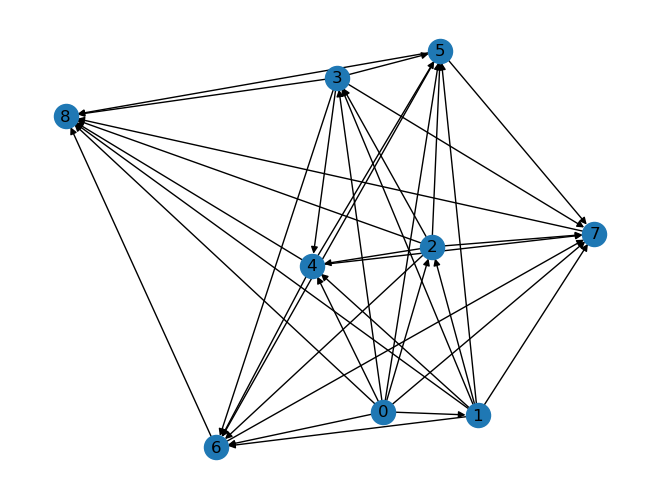

In [11]:
nx.draw(to_networkx(ratio_graph_dataset[0]), with_labels=True)

In [12]:
# load the indices of the validation sets from the ML models
data_split_indices = load_file('data_split_indices.pkl')

# GCN models:

### GCNConv with log_softmax activation function and NLLLoss

In [13]:
#Model
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
from torch.nn import Dropout1d
import seaborn as sns
import matplotlib.pyplot as plt

n_features = 25 # [Delta, Theta, Alpha, Beta, Gamma] * [mean, median, std, skew, kurt]
param = 64
num_classes = 5 # healthy, ADHD, MDD, OCD, SMC

class GCN(pl.LightningModule):
    def __init__(self, learning_rate, optimizer_name, dropout):
        super(GCN, self).__init__()
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name

        self.conv1 = GCNConv(n_features, param, cached=False) # if you defined cache=True, the shape of batch must be same!
        self.bn1 = BatchNorm1d(param)
        self.do1 = Dropout1d(p=dropout)
        self.conv2 = GCNConv(param, param, cached=False)
        self.bn2 = BatchNorm1d(param)
        self.do2 = Dropout1d(p=dropout)
        self.fc1 = Linear(param, param)
        self.bn3 = BatchNorm1d(param)
        self.do3 = Dropout1d(p=dropout)
        self.fc2 = Linear(param, 8)
        self.fc3 = Linear(8, num_classes)

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_cm = ConfusionMatrix(task = 'binary', num_classes=num_classes, threshold=0.05)
        self.validation_step_yhats = []
        self.validation_step_ys = []

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = self.do1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = self.do2(x)
        x = global_add_pool(x, data.batch)
        x = F.relu(self.fc1(x))
        x = self.bn3(x)
        x = self.do3(x)
        x = F.relu(self.fc2(x))
        #x = F.dropout(x, p=0.2, training=self.training)
        x = torch.flatten(x, start_dim=1)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1) # Activation function for classification
        return x
    
    def configure_optimizers(self):
        if self.optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
            x, y = train_batch.x, train_batch.y
            output = self.forward(train_batch)
            loss = F.nll_loss(output, y)
            y_hat = output.argmax(dim=1)
            self.log('train_loss', loss, on_epoch=True, prog_bar=True)
            self.log('train_f1', self.train_f1(y, y_hat), on_epoch=True, prog_bar=True)
            return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch.x, val_batch.y
        output = self.forward(val_batch)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        self.validation_step_yhats.append(y_hat)
        self.validation_step_ys.append(y)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch.x, test_batch.y
        output = self.forward(test_batch)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss

    # def on_train_epoch_end(self, training_step_outputs):
    #     # compute metrics
    #     train_f1 = self.train_f1.compute()
    #     # log metrics
    #     self.log("epoch_train_f1", train_f1)
    #     # reset all metrics
    #     self.train_f1.reset()
    #     print(f"\nf1: {train_f1:.4}")

    # def on_validation_epoch_end(self):
    #     # plot confusion matrix
    #     y_hat = torch.cat(self.validation_step_yhats)
    #     y = torch.cat(self.validation_step_ys)
    #     confusion_matrix = self.val_cm(y_hat, y.int())

    #     confusion_matrix_computed = confusion_matrix.detach().cpu().numpy().astype(int)

    #     df_cm = pd.DataFrame(confusion_matrix_computed)
    #     plt.figure(figsize = (10,7))
    #     fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
    #     plt.close(fig_)
    #     self.loggers[0].experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    #     self.validation_step_yhats.clear() # free memory
    #     self.validation_step_ys.clear()
    
    def predict_step(self, batch):
        x, y = batch.x, batch.y
        output = self.forward(batch)
        y_hat = output.argmax(dim=1)
        return y_hat


    # def backward(self, trainer, loss, optimizer, optimizer_idx):
    #     loss.backward()
    
    # def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx):
    #     optimizer.step()
    #     optimizer.zero_grad()

# 1. EC feature set

In [14]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['EC'][0]
baseline_val_idxs = data_split_indices['EC'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_ec_ids for i in range(12)] # times 12 for each epoch

print(f'{len(ec_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [ec_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [ec_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[ec_y_list[i] for i in baseline_rest_idxs]
Y_val = [ec_y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(ec_graph_dataset) = 2688
len(baseline_rest_idxs) = 2148, len(baseline_val_idxs) = 540, total: 2688
len(X_traintest) = 2148, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 432, total: 2148


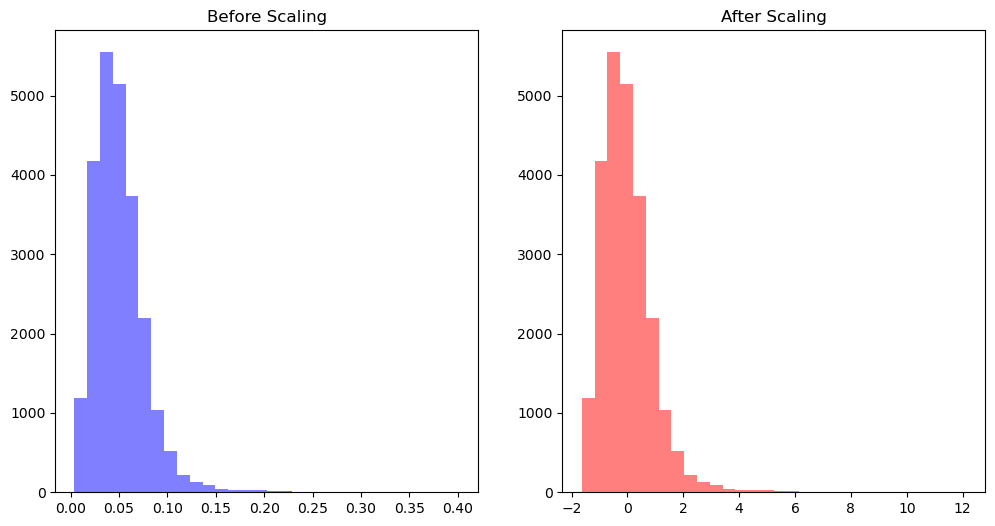

In [15]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val]))


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

### Model: Standard GCN

In [16]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size, dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')
    n_epochs = batch_size * 4 # vary training epochs based on batch size

    # Create the model
    model = GCN(learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=n_epochs,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=100))
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('ec_results_stand_GCN_trials.pkl')

[I 2024-06-19 16:02:39,869] A new study created in memory with name: no-name-4cbe9c93-9bb4-4c31-8e8d-480e03c8d827


Tested parameters: {'learning_rate': 5.278891138895619e-05, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.65970301839911}


/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
[I 2024-06-19 16:04:10,007] Trial 0 finished with value: 0.2858014702796936 and parameters: {'learning_rate': 5.278891138895619e-05, 'optimizer': 'Adam', '

Tested parameters: {'learning_rate': 0.035499781365016615, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.28595420077895667}


[I 2024-06-19 16:07:10,402] Trial 1 finished with value: 0.2825705409049988 and parameters: {'learning_rate': 0.035499781365016615, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.28595420077895667}. Best is trial 0 with value: 0.2858014702796936.


Tested parameters: {'learning_rate': 0.013541245425798045, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.24490420866147666}


[I 2024-06-19 16:08:41,453] Trial 2 finished with value: 0.3056211769580841 and parameters: {'learning_rate': 0.013541245425798045, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.24490420866147666}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.001013991376418598, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.7296247318974541}


[I 2024-06-19 16:11:40,821] Trial 3 finished with value: 0.2750815451145172 and parameters: {'learning_rate': 0.001013991376418598, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.7296247318974541}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.02463942154123037, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.1777887977794042}


[I 2024-06-19 16:14:50,054] Trial 4 finished with value: 0.3048815429210663 and parameters: {'learning_rate': 0.02463942154123037, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.1777887977794042}. Best is trial 2 with value: 0.3056211769580841.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 1.346316459942599e-05, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.6223957877573066}


[I 2024-06-19 16:14:59,358] Trial 5 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 4.5094665847952945e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.6465649873029916}


[I 2024-06-19 16:15:07,178] Trial 6 pruned. Trial was pruned at epoch 100.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 2.1802819037149116e-05, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.5645325231543179}


[I 2024-06-19 16:15:16,058] Trial 7 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 2.5203072623546234e-05, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.05942579679045404}


[I 2024-06-19 16:15:24,429] Trial 8 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.027422520083667704, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.6807969552177249}


[I 2024-06-19 16:15:32,140] Trial 9 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.003311169713331934, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.42996173288809336}


[I 2024-06-19 16:17:01,569] Trial 10 finished with value: 0.30490654706954956 and parameters: {'learning_rate': 0.003311169713331934, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.42996173288809336}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.0036632507239962426, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.4434793388643976}


[I 2024-06-19 16:18:26,939] Trial 11 finished with value: 0.27728691697120667 and parameters: {'learning_rate': 0.0036632507239962426, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.4434793388643976}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.004789295853040825, 'optimizer_name': 'Adam', 'batch_size': 850, 'dropout': 0.3848696918772875}


[I 2024-06-19 16:22:44,948] Trial 12 finished with value: 0.2954462766647339 and parameters: {'learning_rate': 0.004789295853040825, 'optimizer': 'Adam', 'batch_size': 850, 'dropout': 0.3848696918772875}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.000434895724828231, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.24717386551776405}


[I 2024-06-19 16:24:13,402] Trial 13 finished with value: 0.260553777217865 and parameters: {'learning_rate': 0.000434895724828231, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.24717386551776405}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.09809372114564818, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.4422213774133069}


[I 2024-06-19 16:24:27,709] Trial 14 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.005468118201093928, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.11618477643469463}


[I 2024-06-19 16:25:56,464] Trial 15 finished with value: 0.29258203506469727 and parameters: {'learning_rate': 0.005468118201093928, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.11618477643469463}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.000671473054801776, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.34130144205784707}


[I 2024-06-19 16:28:14,816] Trial 16 finished with value: 0.27565261721611023 and parameters: {'learning_rate': 0.000671473054801776, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.34130144205784707}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.002589854391544597, 'optimizer_name': 'Adam', 'batch_size': 850, 'dropout': 0.5175741438550361}


[I 2024-06-19 16:32:32,861] Trial 17 finished with value: 0.3003826141357422 and parameters: {'learning_rate': 0.002589854391544597, 'optimizer': 'Adam', 'batch_size': 850, 'dropout': 0.5175741438550361}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.00017335986751435627, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.00419999302055471}


[I 2024-06-19 16:33:59,923] Trial 18 finished with value: 0.29977869987487793 and parameters: {'learning_rate': 0.00017335986751435627, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.00419999302055471}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.014486887777793464, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.2011135111621008}


[I 2024-06-19 16:35:25,492] Trial 19 finished with value: 0.26391056180000305 and parameters: {'learning_rate': 0.014486887777793464, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.2011135111621008}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.009895759634208119, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.3112935059746701}


[I 2024-06-19 16:36:54,603] Trial 20 finished with value: 0.2837609052658081 and parameters: {'learning_rate': 0.009895759634208119, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.3112935059746701}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.09910672777403172, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.16935689124318798}


[I 2024-06-19 16:37:01,303] Trial 21 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.001597300743854038, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.14307549907676637}


[I 2024-06-19 16:39:48,488] Trial 22 finished with value: 0.28471291065216064 and parameters: {'learning_rate': 0.001597300743854038, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.14307549907676637}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.02795555217698397, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.23180052715385263}


[I 2024-06-19 16:41:58,002] Trial 23 finished with value: 0.2536793053150177 and parameters: {'learning_rate': 0.02795555217698397, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.23180052715385263}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.010663508122700466, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.37390664167775267}


[I 2024-06-19 16:46:29,143] Trial 24 finished with value: 0.2755553424358368 and parameters: {'learning_rate': 0.010663508122700466, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.37390664167775267}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.039566763479443115, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.4842589957432817}


[I 2024-06-19 16:46:37,443] Trial 25 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.012020341141651616, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.2740327373650365}


[I 2024-06-19 16:48:08,794] Trial 26 finished with value: 0.3030170798301697 and parameters: {'learning_rate': 0.012020341141651616, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.2740327373650365}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.002575571831497586, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.1181609966774202}


[I 2024-06-19 16:49:38,477] Trial 27 finished with value: 0.29889482259750366 and parameters: {'learning_rate': 0.002575571831497586, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.1181609966774202}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.007153652938203901, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.0755370206195485}


[I 2024-06-19 16:52:47,071] Trial 28 finished with value: 0.2689429223537445 and parameters: {'learning_rate': 0.007153652938203901, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.0755370206195485}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.00020414683381307766, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.7868202740942404}


[I 2024-06-19 16:53:02,790] Trial 29 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.018792243044195595, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.33453375778614375}


[I 2024-06-19 16:55:12,755] Trial 30 finished with value: 0.30382096767425537 and parameters: {'learning_rate': 0.018792243044195595, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.33453375778614375}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.01971030436956469, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.3322154876030975}


[I 2024-06-19 16:57:28,917] Trial 31 finished with value: 0.275163859128952 and parameters: {'learning_rate': 0.01971030436956469, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.3322154876030975}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.052961479011352855, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.20332384247359903}


[I 2024-06-19 16:59:45,281] Trial 32 finished with value: 0.2942439317703247 and parameters: {'learning_rate': 0.052961479011352855, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.20332384247359903}. Best is trial 2 with value: 0.3056211769580841.


Tested parameters: {'learning_rate': 0.06149309040323311, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.28314316607177215}


[I 2024-06-19 17:01:57,428] Trial 33 finished with value: 0.311802476644516 and parameters: {'learning_rate': 0.06149309040323311, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.28314316607177215}. Best is trial 33 with value: 0.311802476644516.


Tested parameters: {'learning_rate': 0.04690083880501526, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.2812553618446193}


[I 2024-06-19 17:04:10,269] Trial 34 finished with value: 0.2683279514312744 and parameters: {'learning_rate': 0.04690083880501526, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.2812553618446193}. Best is trial 33 with value: 0.311802476644516.


Tested parameters: {'learning_rate': 0.05674058586757688, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.40832030077542214}


[I 2024-06-19 17:07:13,630] Trial 35 finished with value: 0.2793405055999756 and parameters: {'learning_rate': 0.05674058586757688, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.40832030077542214}. Best is trial 33 with value: 0.311802476644516.


Tested parameters: {'learning_rate': 0.0014018146135557044, 'optimizer_name': 'Adam', 'batch_size': 510, 'dropout': 0.5810640565472535}


[I 2024-06-19 17:09:58,909] Trial 36 finished with value: 0.2759847939014435 and parameters: {'learning_rate': 0.0014018146135557044, 'optimizer': 'Adam', 'batch_size': 510, 'dropout': 0.5810640565472535}. Best is trial 33 with value: 0.311802476644516.


Tested parameters: {'learning_rate': 0.008111001659900353, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.192466957924521}


[I 2024-06-19 17:10:05,935] Trial 37 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.023691697753628574, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.24347627295788976}


[I 2024-06-19 17:12:20,659] Trial 38 finished with value: 0.3196799159049988 and parameters: {'learning_rate': 0.023691697753628574, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.24347627295788976}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.0031102446148439013, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.24942189177436008}


[I 2024-06-19 17:14:33,474] Trial 39 finished with value: 0.29251596331596375 and parameters: {'learning_rate': 0.0031102446148439013, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.24942189177436008}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.06459911182712591, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.49610709111318}


[I 2024-06-19 17:16:45,888] Trial 40 finished with value: 0.3176015019416809 and parameters: {'learning_rate': 0.06459911182712591, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.49610709111318}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.07082833697431234, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.5121885912288183}


[I 2024-06-19 17:18:59,178] Trial 41 finished with value: 0.28472012281417847 and parameters: {'learning_rate': 0.07082833697431234, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.5121885912288183}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.03852819005440506, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.43008436327959626}


[I 2024-06-19 17:21:15,408] Trial 42 finished with value: 0.293682336807251 and parameters: {'learning_rate': 0.03852819005440506, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.43008436327959626}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.02444029702549376, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.36086054518706917}


[I 2024-06-19 17:23:25,223] Trial 43 finished with value: 0.30570441484451294 and parameters: {'learning_rate': 0.02444029702549376, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.36086054518706917}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.02709443777035846, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.30222074310398717}


[I 2024-06-19 17:25:38,414] Trial 44 finished with value: 0.2906147539615631 and parameters: {'learning_rate': 0.02709443777035846, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.30222074310398717}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.015812974699923994, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.3729914844408242}


[I 2024-06-19 17:27:54,378] Trial 45 finished with value: 0.3163609504699707 and parameters: {'learning_rate': 0.015812974699923994, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.3729914844408242}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.07419796377193164, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.48333157112293496}


[I 2024-06-19 17:30:07,190] Trial 46 finished with value: 0.30329951643943787 and parameters: {'learning_rate': 0.07419796377193164, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.48333157112293496}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.018118206693451763, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.3618642129921112}


[I 2024-06-19 17:32:25,453] Trial 47 finished with value: 0.28414133191108704 and parameters: {'learning_rate': 0.018118206693451763, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.3618642129921112}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.0321222848243178, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.5860031426474441}


[I 2024-06-19 17:34:41,520] Trial 48 finished with value: 0.3130236268043518 and parameters: {'learning_rate': 0.0321222848243178, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.5860031426474441}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.03477890801252628, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.6779294995887877}


[I 2024-06-19 17:36:59,881] Trial 49 finished with value: 0.2795857787132263 and parameters: {'learning_rate': 0.03477890801252628, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.6779294995887877}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.07500295416686954, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.5879718705032237}


[I 2024-06-19 17:37:09,946] Trial 50 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.023214122488790623, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.6166110480681359}


[I 2024-06-19 17:39:18,893] Trial 51 finished with value: 0.2923405170440674 and parameters: {'learning_rate': 0.023214122488790623, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.6166110480681359}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.014539126829210608, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.5493189354190375}


[I 2024-06-19 17:41:34,092] Trial 52 finished with value: 0.2913726568222046 and parameters: {'learning_rate': 0.014539126829210608, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.5493189354190375}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.03245014639507561, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.4039407211923277}


[I 2024-06-19 17:43:44,836] Trial 53 finished with value: 0.30919116735458374 and parameters: {'learning_rate': 0.03245014639507561, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.4039407211923277}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.0594030858308314, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.49633407312657024}


[I 2024-06-19 17:46:05,849] Trial 54 finished with value: 0.29358839988708496 and parameters: {'learning_rate': 0.0594030858308314, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.49633407312657024}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.035327133106268824, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.4642166753290013}


[I 2024-06-19 17:48:23,905] Trial 55 finished with value: 0.2539658546447754 and parameters: {'learning_rate': 0.035327133106268824, 'optimizer': 'SGD', 'batch_size': 340, 'dropout': 0.4642166753290013}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.09543891206789032, 'optimizer_name': 'Adam', 'batch_size': 850, 'dropout': 0.4019550907202533}


[I 2024-06-19 17:52:45,059] Trial 56 finished with value: 0.2810326814651489 and parameters: {'learning_rate': 0.09543891206789032, 'optimizer': 'Adam', 'batch_size': 850, 'dropout': 0.4019550907202533}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.005663859140277034, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.5381970996057763}


[I 2024-06-19 17:55:03,060] Trial 57 finished with value: 0.28451651334762573 and parameters: {'learning_rate': 0.005663859140277034, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.5381970996057763}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.04608479759779533, 'optimizer_name': 'Adam', 'batch_size': 510, 'dropout': 0.6388266041873575}


[I 2024-06-19 17:57:45,293] Trial 58 finished with value: 0.25378456711769104 and parameters: {'learning_rate': 0.04608479759779533, 'optimizer': 'Adam', 'batch_size': 510, 'dropout': 0.6388266041873575}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.014511479414924089, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.4174703168429966}


[I 2024-06-19 17:59:55,121] Trial 59 finished with value: 0.2931392788887024 and parameters: {'learning_rate': 0.014511479414924089, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.4174703168429966}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.03484988008376838, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.7119995268411411}


[I 2024-06-19 18:02:04,989] Trial 60 finished with value: 0.2716328501701355 and parameters: {'learning_rate': 0.03484988008376838, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.7119995268411411}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.02753627237529846, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.37271193428877847}


[I 2024-06-19 18:04:18,695] Trial 61 finished with value: 0.28383544087409973 and parameters: {'learning_rate': 0.02753627237529846, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.37271193428877847}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.02235007008410278, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.45478061934523945}


[I 2024-06-19 18:06:28,742] Trial 62 finished with value: 0.2695936858654022 and parameters: {'learning_rate': 0.02235007008410278, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.45478061934523945}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.008909679328989204, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.31639742420557854}


[I 2024-06-19 18:08:47,727] Trial 63 finished with value: 0.29209935665130615 and parameters: {'learning_rate': 0.008909679328989204, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.31639742420557854}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.0662953112291574, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.35798192359278}


[I 2024-06-19 18:11:01,917] Trial 64 finished with value: 0.27718955278396606 and parameters: {'learning_rate': 0.0662953112291574, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.35798192359278}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.01656199078919685, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.2618594919319927}


[I 2024-06-19 18:11:09,648] Trial 65 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 1.0705551108509072e-05, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.39270104240275755}


[I 2024-06-19 18:11:19,998] Trial 66 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 5.0877240554386314e-05, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.2348068749528306}


[I 2024-06-19 18:11:30,780] Trial 67 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.030146328987850114, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.21987124975994932}


[I 2024-06-19 18:13:45,483] Trial 68 finished with value: 0.29833823442459106 and parameters: {'learning_rate': 0.030146328987850114, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.21987124975994932}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.04760719320799116, 'optimizer_name': 'Adam', 'batch_size': 510, 'dropout': 0.28781915023806137}


[I 2024-06-19 18:16:25,557] Trial 69 finished with value: 0.27295151352882385 and parameters: {'learning_rate': 0.04760719320799116, 'optimizer': 'Adam', 'batch_size': 510, 'dropout': 0.28781915023806137}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.010516898500054387, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.3410411846332393}


[I 2024-06-19 18:18:40,643] Trial 70 finished with value: 0.2734147012233734 and parameters: {'learning_rate': 0.010516898500054387, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.3410411846332393}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.012405787932758839, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.1770757340033219}


[I 2024-06-19 18:20:14,320] Trial 71 finished with value: 0.2980634272098541 and parameters: {'learning_rate': 0.012405787932758839, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.1770757340033219}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.02408731719731944, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.29916187277737244}


[I 2024-06-19 18:21:40,249] Trial 72 finished with value: 0.3063804507255554 and parameters: {'learning_rate': 0.02408731719731944, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.29916187277737244}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.023261229297434637, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.3055638536970341}


[I 2024-06-19 18:23:53,585] Trial 73 finished with value: 0.29872509837150574 and parameters: {'learning_rate': 0.023261229297434637, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.3055638536970341}. Best is trial 38 with value: 0.3196799159049988.


Tested parameters: {'learning_rate': 0.09910923183968892, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.2714679202421886}


[I 2024-06-19 18:24:07,476] Trial 74 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 8.747270067912998e-05, 'optimizer_name': 'Adam', 'batch_size': 850, 'dropout': 0.3278663283175011}


[I 2024-06-19 18:24:15,554] Trial 75 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.049283886807520265, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.15124394269106298}


[I 2024-06-19 18:24:26,281] Trial 76 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.041528435669348926, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.38514162027223237}


[I 2024-06-19 18:25:53,335] Trial 77 finished with value: 0.32447221875190735 and parameters: {'learning_rate': 0.041528435669348926, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.38514162027223237}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.0005616312153141455, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.44352942346910035}


[I 2024-06-19 18:26:06,469] Trial 78 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.006402113783090426, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.38816693110547373}


[I 2024-06-19 18:26:19,353] Trial 79 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.04097140326061246, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.4702223749675182}


[I 2024-06-19 18:27:47,244] Trial 80 finished with value: 0.2985175848007202 and parameters: {'learning_rate': 0.04097140326061246, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.4702223749675182}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.030287045168501864, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.3548452329347903}


[I 2024-06-19 18:29:13,249] Trial 81 finished with value: 0.2970016896724701 and parameters: {'learning_rate': 0.030287045168501864, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.3548452329347903}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.019104338341191632, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.2968744438665807}


[I 2024-06-19 18:31:25,752] Trial 82 finished with value: 0.28383439779281616 and parameters: {'learning_rate': 0.019104338341191632, 'optimizer': 'SGD', 'batch_size': 340, 'dropout': 0.2968744438665807}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.0760189017392202, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.4173895092314624}


[I 2024-06-19 18:31:38,516] Trial 83 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.06100959160418302, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.37771310628149224}


[I 2024-06-19 18:33:50,054] Trial 84 finished with value: 0.31520363688468933 and parameters: {'learning_rate': 0.06100959160418302, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.37771310628149224}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.05948179038283251, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.38271832241031506}


[I 2024-06-19 18:37:02,671] Trial 85 finished with value: 0.2659305930137634 and parameters: {'learning_rate': 0.05948179038283251, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.38271832241031506}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.08368299876455959, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.25434210995307915}


[I 2024-06-19 18:39:15,374] Trial 86 finished with value: 0.29025956988334656 and parameters: {'learning_rate': 0.08368299876455959, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.25434210995307915}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.04116531731750473, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.5279966967492458}


[I 2024-06-19 18:39:23,009] Trial 87 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.051780036868271505, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.5876228735779482}


[I 2024-06-19 18:41:35,892] Trial 88 finished with value: 0.27347666025161743 and parameters: {'learning_rate': 0.051780036868271505, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.5876228735779482}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.03402578045982537, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.5055575044139012}


[I 2024-06-19 18:43:00,219] Trial 89 finished with value: 0.2829977571964264 and parameters: {'learning_rate': 0.03402578045982537, 'optimizer': 'SGD', 'batch_size': 170, 'dropout': 0.5055575044139012}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.004020175418706714, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.32185745448663383}


[I 2024-06-19 18:45:10,779] Trial 90 finished with value: 0.2828378975391388 and parameters: {'learning_rate': 0.004020175418706714, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.32185745448663383}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.02395626371416651, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.35447537373118454}


[I 2024-06-19 18:47:28,597] Trial 91 finished with value: 0.30203837156295776 and parameters: {'learning_rate': 0.02395626371416651, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.35447537373118454}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.06000521352389817, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.4274658563482749}


[I 2024-06-19 18:49:42,261] Trial 92 finished with value: 0.29564350843429565 and parameters: {'learning_rate': 0.06000521352389817, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.4274658563482749}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.015977684804303567, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.3375425644030329}


[I 2024-06-19 18:51:54,974] Trial 93 finished with value: 0.3016459345817566 and parameters: {'learning_rate': 0.015977684804303567, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.3375425644030329}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.020947202847105835, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.5655572307797241}


[I 2024-06-19 18:54:06,581] Trial 94 finished with value: 0.2891279458999634 and parameters: {'learning_rate': 0.020947202847105835, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.5655572307797241}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.030111914945526976, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.2154613011306779}


[I 2024-06-19 18:56:20,952] Trial 95 finished with value: 0.290662944316864 and parameters: {'learning_rate': 0.030111914945526976, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.2154613011306779}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.03922872163642321, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.36924851226124317}


[I 2024-06-19 18:58:34,866] Trial 96 finished with value: 0.2886238694190979 and parameters: {'learning_rate': 0.03922872163642321, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.36924851226124317}. Best is trial 77 with value: 0.32447221875190735.


Tested parameters: {'learning_rate': 0.07686907151872058, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.4022781788461876}


[I 2024-06-19 19:00:47,077] Trial 97 finished with value: 0.34020644426345825 and parameters: {'learning_rate': 0.07686907151872058, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.4022781788461876}. Best is trial 97 with value: 0.34020644426345825.


Tested parameters: {'learning_rate': 0.08359514274507446, 'optimizer_name': 'Adam', 'batch_size': 850, 'dropout': 0.407866417394333}


[I 2024-06-19 19:05:08,664] Trial 98 finished with value: 0.2817581593990326 and parameters: {'learning_rate': 0.08359514274507446, 'optimizer': 'Adam', 'batch_size': 850, 'dropout': 0.407866417394333}. Best is trial 97 with value: 0.34020644426345825.


Tested parameters: {'learning_rate': 0.0634894307194519, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.4857638260471636}


[I 2024-06-19 19:07:20,722] Trial 99 finished with value: 0.2745268940925598 and parameters: {'learning_rate': 0.0634894307194519, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.4857638260471636}. Best is trial 97 with value: 0.34020644426345825.


Best trial:
  Value: 0.34020644426345825
  Params: 
    learning_rate: 0.07686907151872058
    optimizer: Adam
    batch_size: 340
    dropout: 0.4022781788461876


In [17]:
df_trials = pd.read_pickle('ec_results_stand_GCN_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
97      97  0.340206 2024-06-19 18:58:34.867597 2024-06-19 19:00:47.076367   
77      77  0.324472 2024-06-19 18:24:26.282106 2024-06-19 18:25:53.334205   
38      38  0.319680 2024-06-19 17:10:05.936788 2024-06-19 17:12:20.658018   
40      40  0.317602 2024-06-19 17:14:33.475655 2024-06-19 17:16:45.886361   
45      45  0.316361 2024-06-19 17:25:38.415611 2024-06-19 17:27:54.376828   
84      84  0.315204 2024-06-19 18:31:38.517310 2024-06-19 18:33:50.053547   
48      48  0.313024 2024-06-19 17:32:25.454071 2024-06-19 17:34:41.518655   
33      33  0.311802 2024-06-19 16:59:45.282048 2024-06-19 17:01:57.427077   
53      53  0.309191 2024-06-19 17:41:34.093401 2024-06-19 17:43:44.834867   
72      72  0.306380 2024-06-19 18:20:14.322085 2024-06-19 18:21:40.248356   

                 duration  params_batch_size  params_dropout  \
97 0 days 00:02:12.208770                340        0.402278   
77 0 days 00:01:27.052099                170        0.385142   
38 0 days 00:02:14.721230                340        0.243476   
40 0 days 00:02:12.410706                340        0.496107   
45 0 days 00:02:15.961217                340        0.372991   
84 0 days 00:02:11.536237                340        0.377713   
48 0 days 00:02:16.064584                340        0.586003   
33 0 days 00:02:12.145029                340        0.283143   
53 0 days 00:02:10.741466                340        0.403941   
72 0 days 00:01:25.926271                170        0.299162   

    params_learning_rate params_optimizer     state  
97              0.076869             Adam  COMPLETE  
77              0.041528              SGD  COMPLETE  
38              0.023692             Adam  COMPLETE  
40              0.064599             Adam  COMPLETE  
45              0.015813             Adam  COMPLETE  
84              0.061010             Adam  COMPLETE  
48              0.032122             Adam  COMPLETE  
33              0.061493             Adam  COMPLETE  
53              0.032450             Adam  COMPLETE  
72              0.024087             Adam  COMPLETE

#### Visualizations

In [18]:
# function to change axes size
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

/tmp/ipykernel_190012/1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

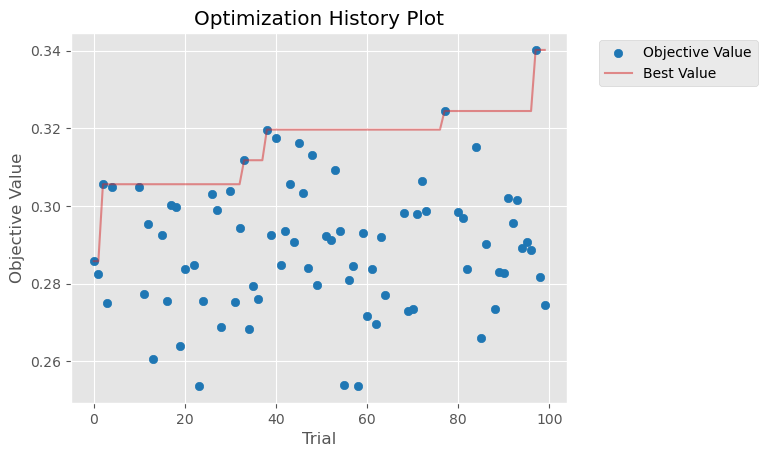

In [19]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-06-19 19:07:21,096] A new study created in memory with name: no-name-b53f4a1c-1787-40c8-ae20-f1a3f0672aaf
/tmp/ipykernel_190012/3414932042.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


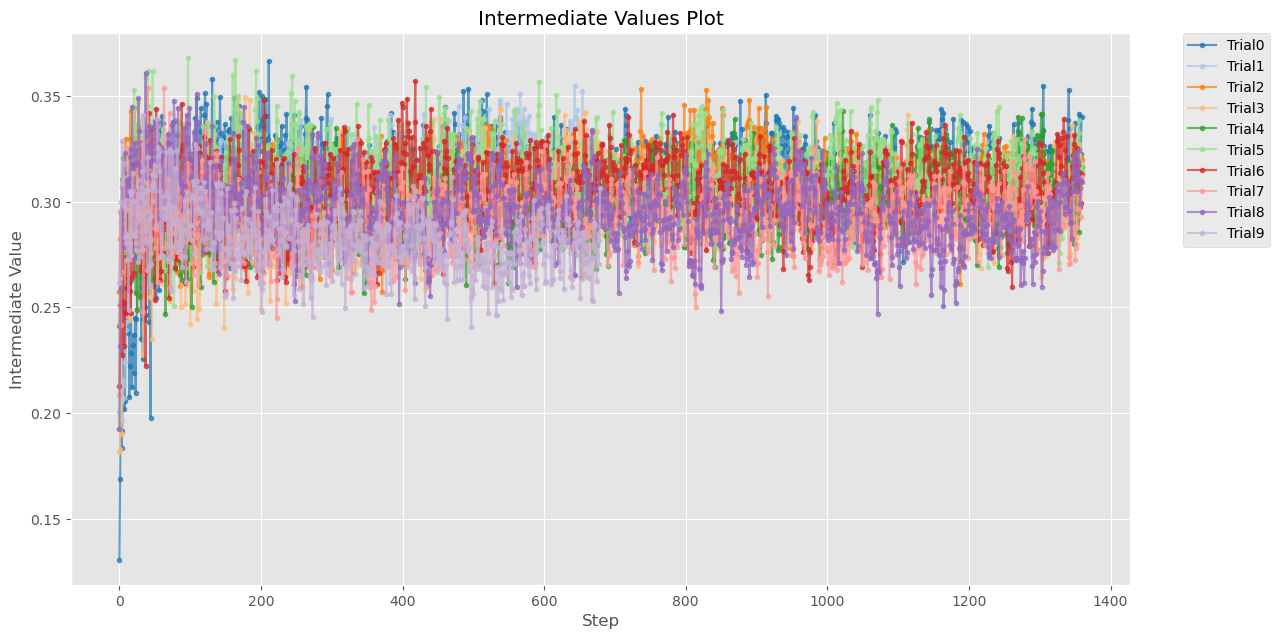

In [20]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value, reverse=True)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

/tmp/ipykernel_190012/2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


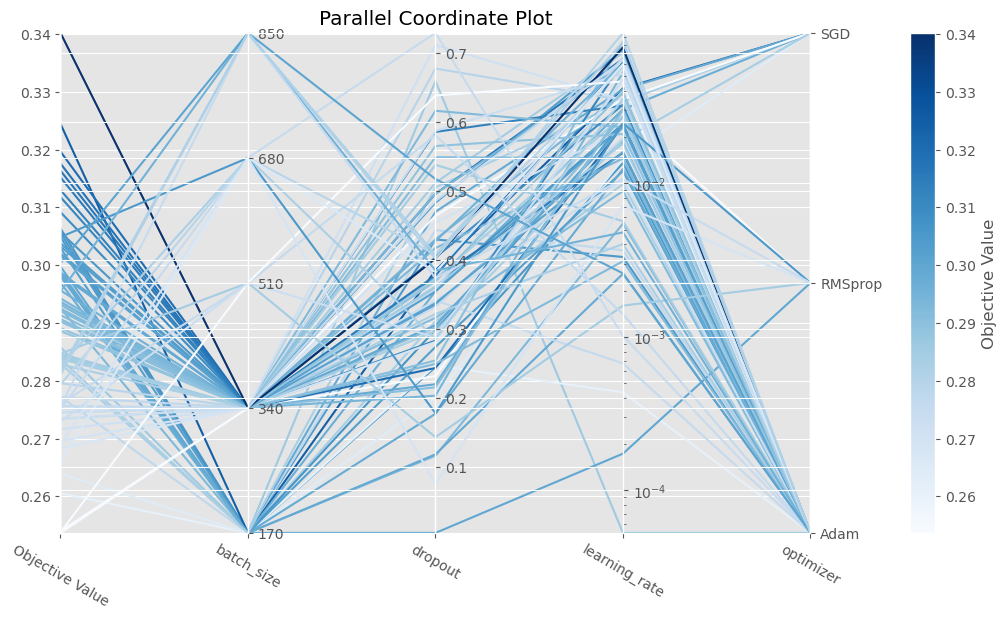

In [21]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

/tmp/ipykernel_190012/624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-06-19 19:07:22,312] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


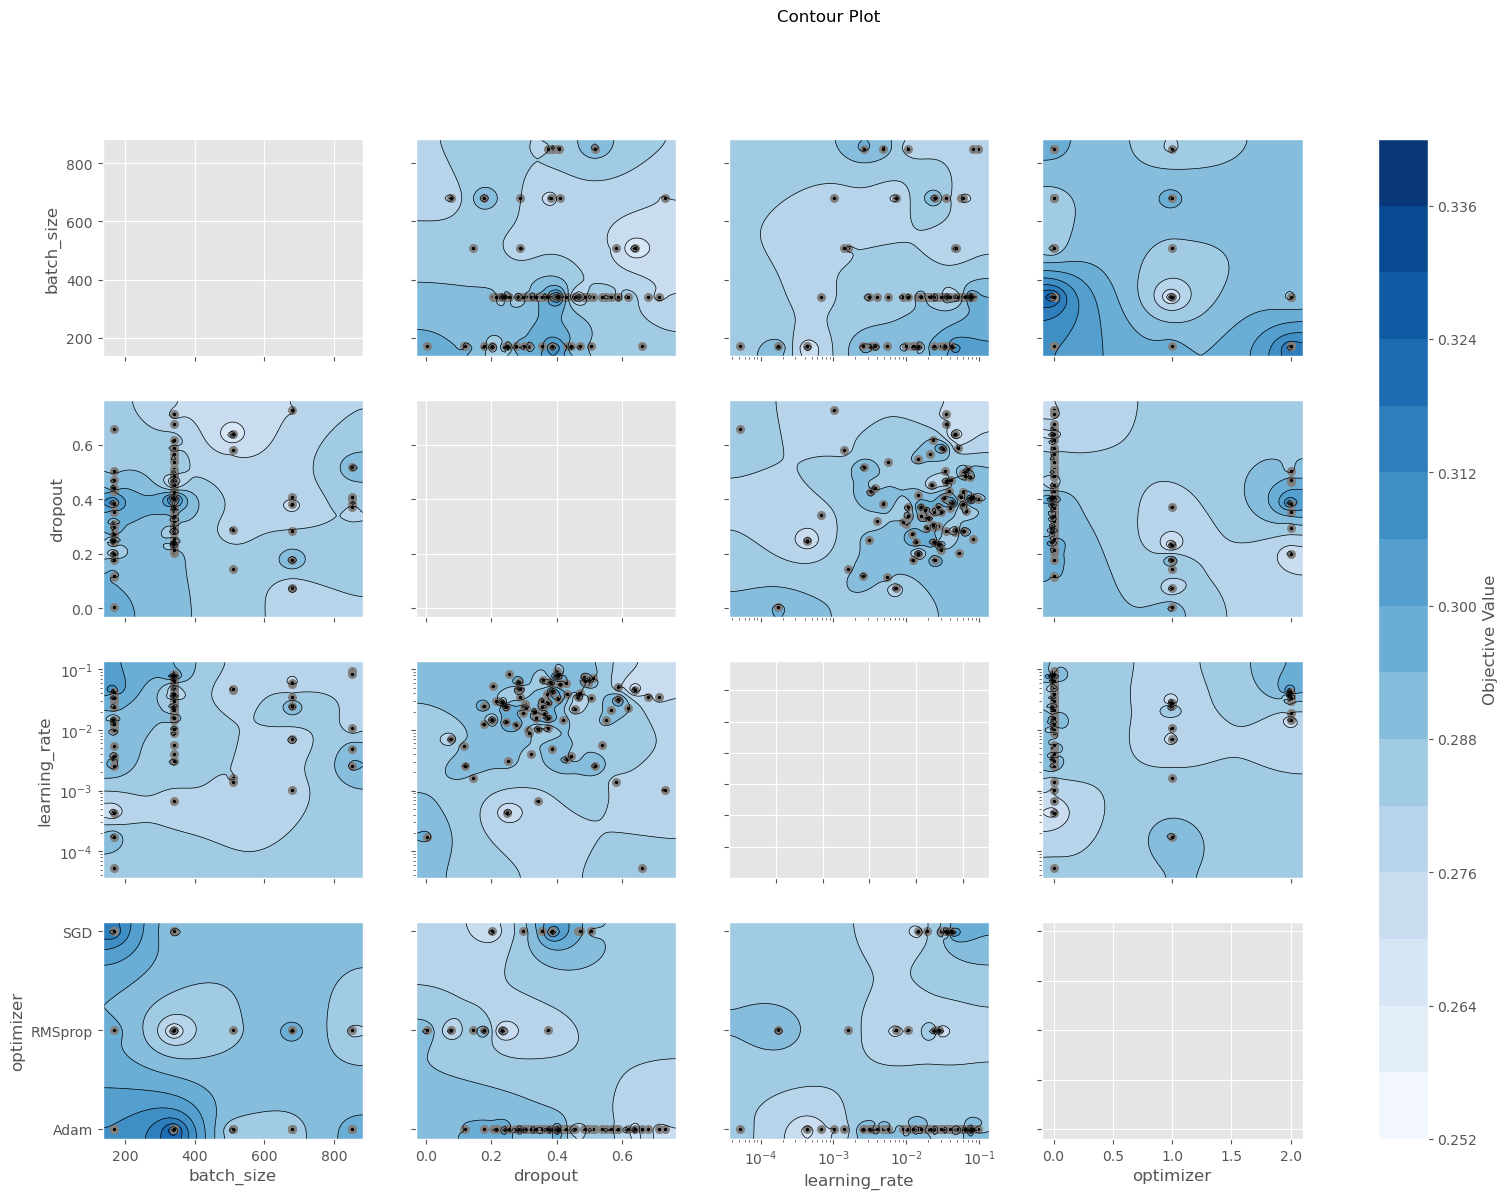

In [22]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

/tmp/ipykernel_190012/1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='learning_rate'>,
       <Axes: xlabel='optimizer'>], dtype=object)

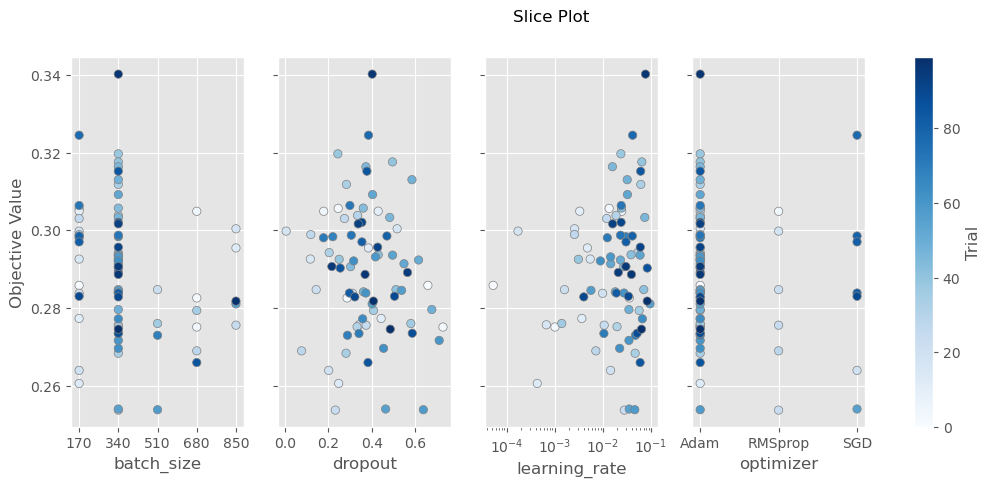

In [23]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

/tmp/ipykernel_190012/1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

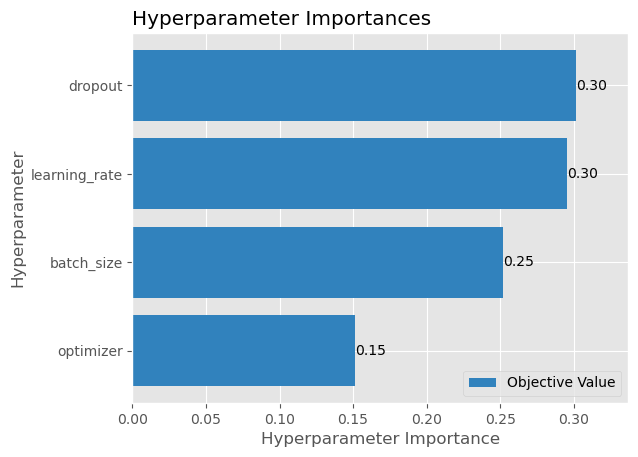

In [24]:
# Visualize parameter importances.
plot_param_importances(study)

/tmp/ipykernel_190012/3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

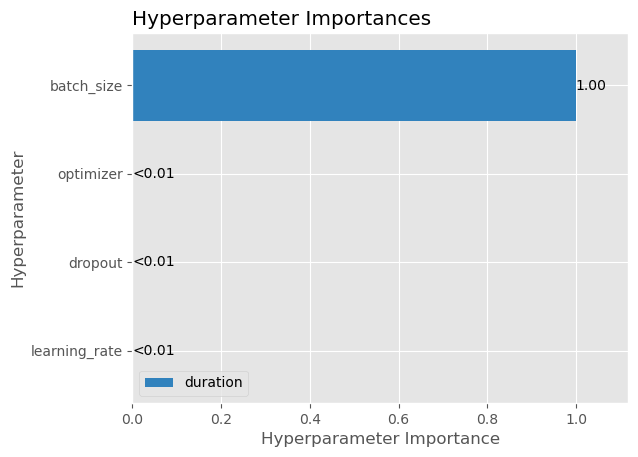

In [25]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

/tmp/ipykernel_190012/1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

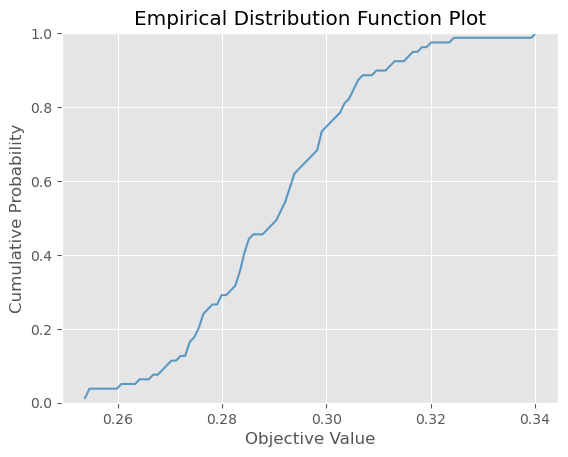

In [26]:
# Visualize empirical distribution function.
plot_edf(study)

/tmp/ipykernel_190012/1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-06-19 19:07:28,359] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


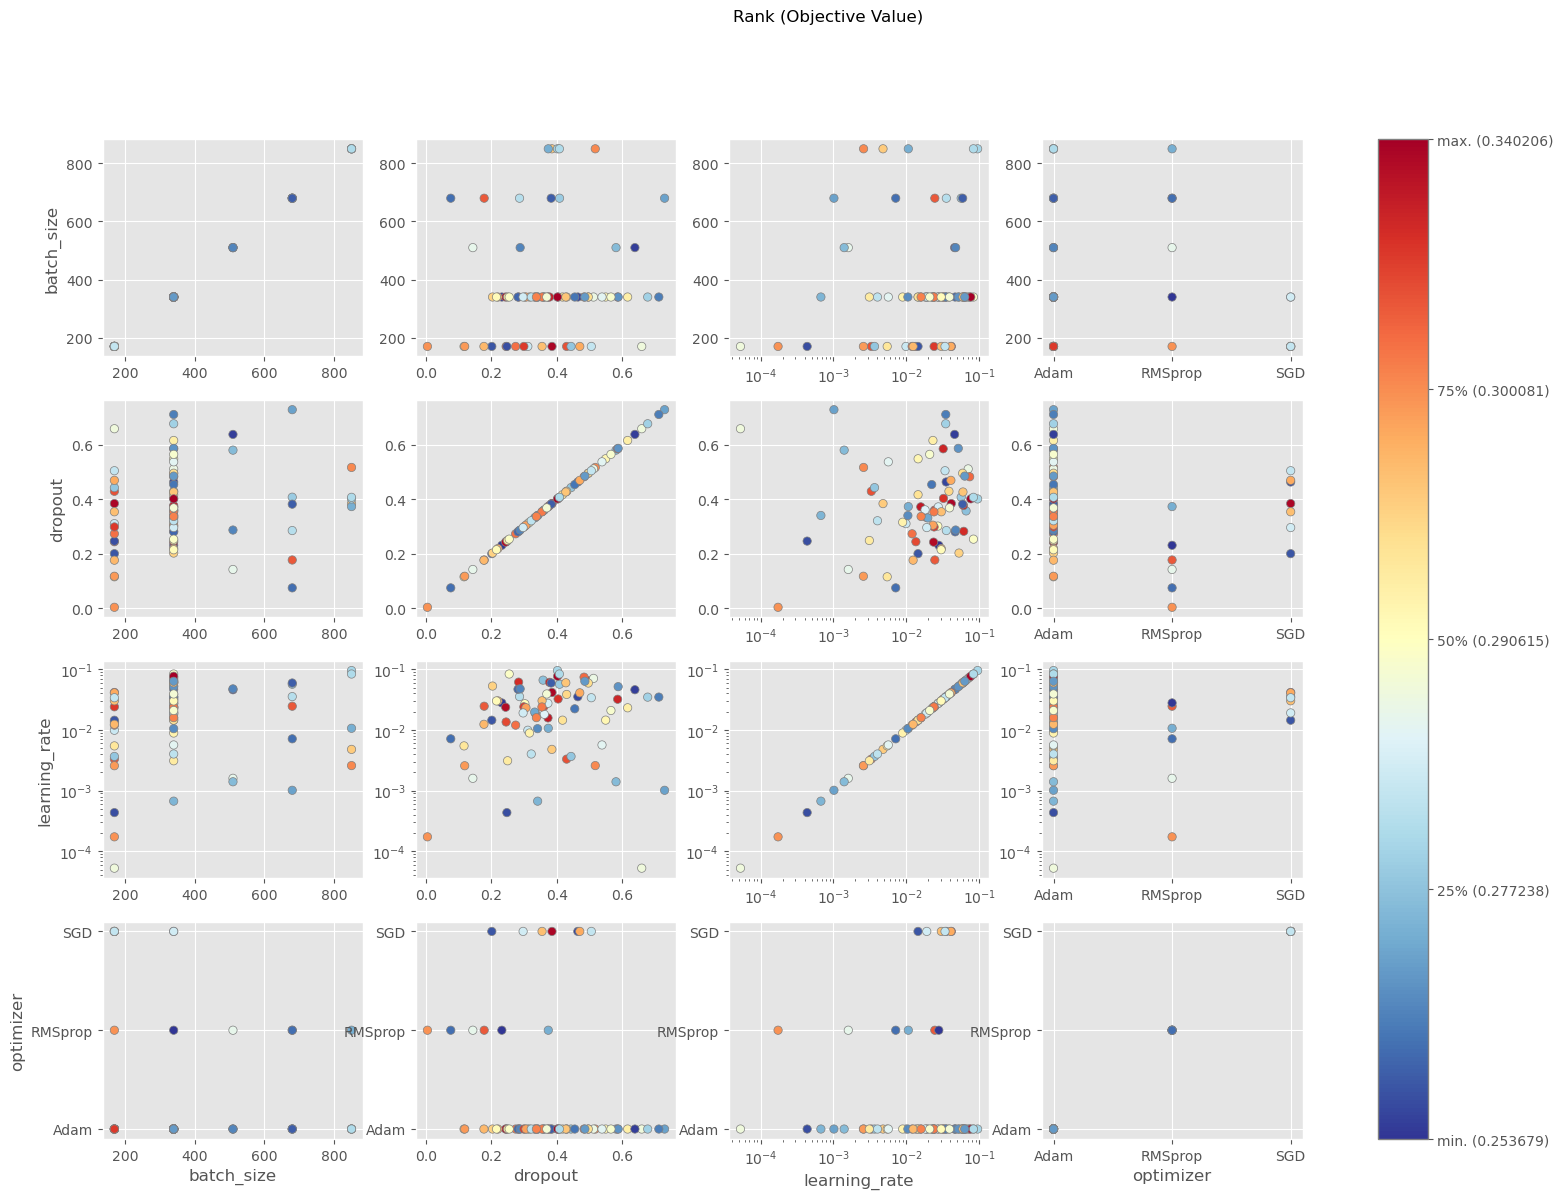

In [27]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

/tmp/ipykernel_190012/124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


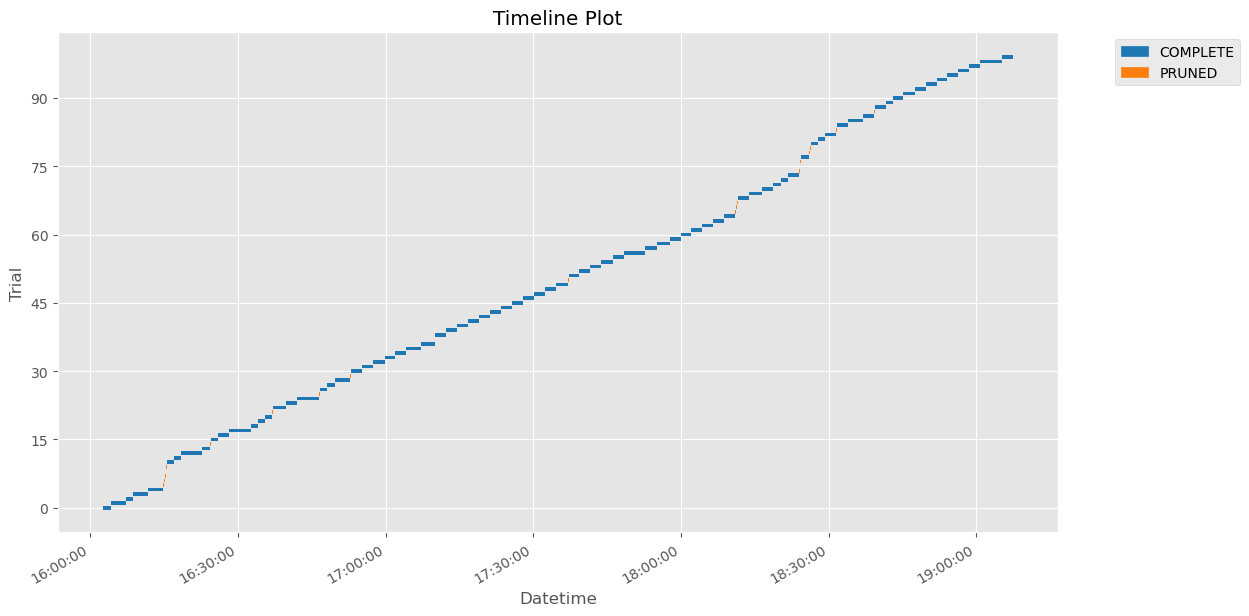

In [28]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)

# 2. EO feature set

In [29]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['EO'][0]
baseline_val_idxs = data_split_indices['EO'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_eo_ids for i in range(12)] # times 12 for each epoch

print(f'{len(eo_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [eo_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [eo_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[eo_y_list[i] for i in baseline_rest_idxs]
Y_val = [eo_y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(eo_graph_dataset) = 2700
len(baseline_rest_idxs) = 2160, len(baseline_val_idxs) = 540, total: 2700
len(X_traintest) = 2160, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 444, total: 2160


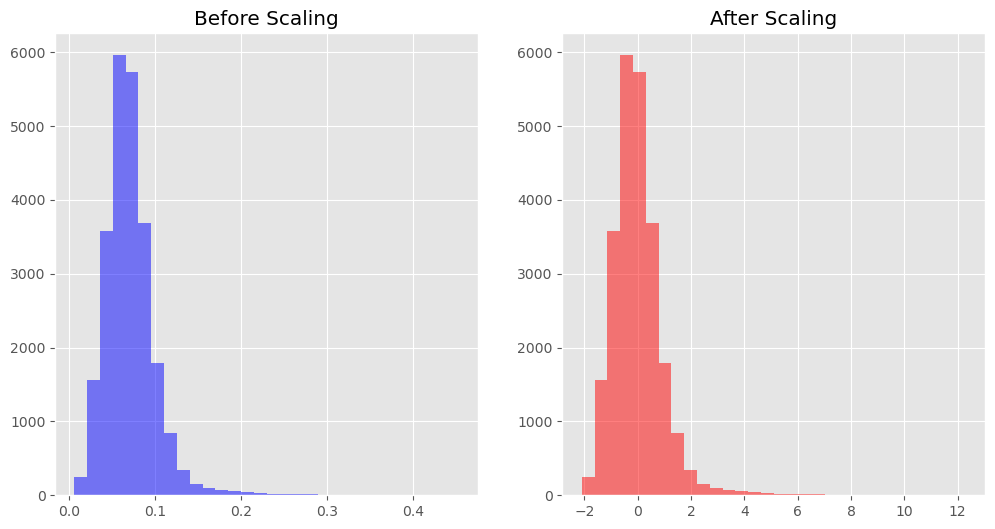

In [30]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val])) # fit on training and validation data


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

### Model: standard GCN

In [31]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size, dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')
    n_epochs = batch_size * 4 # vary training epochs based on batch size

    # Create the model
    model = GCN(learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=n_epochs,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=100))
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('eo_results_stand_GCN_trials.pkl')

[I 2024-06-19 19:07:32,074] A new study created in memory with name: no-name-29b0ccdd-3b59-4ce9-83cf-0b4fc380c317
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.04000405018800679, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.2970982823375297}


[I 2024-06-19 19:10:25,126] Trial 0 finished with value: 0.2749686539173126 and parameters: {'learning_rate': 0.04000405018800679, 'optimizer': 'SGD', 'batch_size': 510, 'dropout': 0.2970982823375297}. Best is trial 0 with value: 0.2749686539173126.


Tested parameters: {'learning_rate': 0.0005595516761108869, 'optimizer_name': 'Adam', 'batch_size': 510, 'dropout': 0.25709324100974157}


[I 2024-06-19 19:13:08,361] Trial 1 finished with value: 0.29415467381477356 and parameters: {'learning_rate': 0.0005595516761108869, 'optimizer': 'Adam', 'batch_size': 510, 'dropout': 0.25709324100974157}. Best is trial 1 with value: 0.29415467381477356.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 5.527210320118594e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.3431675759937483}


[I 2024-06-19 19:16:19,461] Trial 2 finished with value: 0.29737919569015503 and parameters: {'learning_rate': 5.527210320118594e-05, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.3431675759937483}. Best is trial 2 with value: 0.29737919569015503.


Tested parameters: {'learning_rate': 0.0003922993616963624, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.32796940063508684}


[I 2024-06-19 19:19:42,972] Trial 3 finished with value: 0.30356264114379883 and parameters: {'learning_rate': 0.0003922993616963624, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.32796940063508684}. Best is trial 3 with value: 0.30356264114379883.


Tested parameters: {'learning_rate': 0.005988428599663805, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.6712782273222766}


[I 2024-06-19 19:23:07,578] Trial 4 finished with value: 0.30375179648399353 and parameters: {'learning_rate': 0.005988428599663805, 'optimizer': 'SGD', 'batch_size': 680, 'dropout': 0.6712782273222766}. Best is trial 4 with value: 0.30375179648399353.


Tested parameters: {'learning_rate': 5.376154135045906e-05, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.3024745806775835}


[I 2024-06-19 19:23:14,538] Trial 5 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.007001352138623376, 'optimizer_name': 'Adam', 'batch_size': 850, 'dropout': 0.37649649072832886}


[I 2024-06-19 19:27:49,862] Trial 6 finished with value: 0.2774719297885895 and parameters: {'learning_rate': 0.007001352138623376, 'optimizer': 'Adam', 'batch_size': 850, 'dropout': 0.37649649072832886}. Best is trial 4 with value: 0.30375179648399353.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.0859148181441935, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.11592093967235045}


[I 2024-06-19 19:30:02,640] Trial 7 finished with value: 0.29575133323669434 and parameters: {'learning_rate': 0.0859148181441935, 'optimizer': 'SGD', 'batch_size': 340, 'dropout': 0.11592093967235045}. Best is trial 4 with value: 0.30375179648399353.


Tested parameters: {'learning_rate': 1.0995591574507597e-05, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.6674036714860827}


[I 2024-06-19 19:30:10,952] Trial 8 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 1.0070583108217966e-05, 'optimizer_name': 'SGD', 'batch_size': 850, 'dropout': 0.6984795142035236}


[I 2024-06-19 19:30:19,236] Trial 9 pruned. Trial was pruned at epoch 100.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.0037368429307701842, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.5453522147138361}


[I 2024-06-19 19:30:31,981] Trial 10 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0006827190498494541, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.5422237286705937}


[I 2024-06-19 19:33:42,008] Trial 11 finished with value: 0.28392329812049866 and parameters: {'learning_rate': 0.0006827190498494541, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.5422237286705937}. Best is trial 4 with value: 0.30375179648399353.


Tested parameters: {'learning_rate': 0.00412524533028919, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.5128180271109684}


[I 2024-06-19 19:36:52,422] Trial 12 finished with value: 0.2971732020378113 and parameters: {'learning_rate': 0.00412524533028919, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.5128180271109684}. Best is trial 4 with value: 0.30375179648399353.


Tested parameters: {'learning_rate': 0.0003196098878124369, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.046349497340487045}


[I 2024-06-19 19:40:00,886] Trial 13 finished with value: 0.3058815002441406 and parameters: {'learning_rate': 0.0003196098878124369, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.046349497340487045}. Best is trial 13 with value: 0.3058815002441406.


Tested parameters: {'learning_rate': 0.019837781711231826, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.029318707543795983}


[I 2024-06-19 19:42:16,764] Trial 14 finished with value: 0.2572702169418335 and parameters: {'learning_rate': 0.019837781711231826, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.029318707543795983}. Best is trial 13 with value: 0.3058815002441406.


Tested parameters: {'learning_rate': 0.00016464632701330148, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.1660865725194814}


[I 2024-06-19 19:42:29,699] Trial 15 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0017980010861368939, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7951195780191584}


[I 2024-06-19 19:45:36,089] Trial 16 finished with value: 0.2973109781742096 and parameters: {'learning_rate': 0.0017980010861368939, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7951195780191584}. Best is trial 13 with value: 0.3058815002441406.


Tested parameters: {'learning_rate': 0.012303220690583717, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.4715913999098935}


[I 2024-06-19 19:48:44,956] Trial 17 finished with value: 0.3203330934047699 and parameters: {'learning_rate': 0.012303220690583717, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.4715913999098935}. Best is trial 17 with value: 0.3203330934047699.


Tested parameters: {'learning_rate': 0.021168051987071192, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.45359144109397437}


[I 2024-06-19 19:51:53,625] Trial 18 finished with value: 0.30373626947402954 and parameters: {'learning_rate': 0.021168051987071192, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.45359144109397437}. Best is trial 17 with value: 0.3203330934047699.


Tested parameters: {'learning_rate': 0.00020807527576030595, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.21133880304788552}


[I 2024-06-19 19:54:07,435] Trial 19 finished with value: 0.29128557443618774 and parameters: {'learning_rate': 0.00020807527576030595, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.21133880304788552}. Best is trial 17 with value: 0.3203330934047699.


Tested parameters: {'learning_rate': 0.0015326450458033698, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.023874366218026362}


[I 2024-06-19 19:55:36,874] Trial 20 finished with value: 0.3273915648460388 and parameters: {'learning_rate': 0.0015326450458033698, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.023874366218026362}. Best is trial 20 with value: 0.3273915648460388.


Tested parameters: {'learning_rate': 0.0011192480025114752, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.0106558483260361}


[I 2024-06-19 19:57:10,720] Trial 21 finished with value: 0.3267453908920288 and parameters: {'learning_rate': 0.0011192480025114752, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.0106558483260361}. Best is trial 20 with value: 0.3273915648460388.


Tested parameters: {'learning_rate': 0.001462163380584146, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.09617131013081887}


[I 2024-06-19 19:58:38,385] Trial 22 finished with value: 0.2886487543582916 and parameters: {'learning_rate': 0.001462163380584146, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.09617131013081887}. Best is trial 20 with value: 0.3273915648460388.


Tested parameters: {'learning_rate': 0.011756883583691211, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.01477880737867332}


[I 2024-06-19 20:00:09,992] Trial 23 finished with value: 0.2632245421409607 and parameters: {'learning_rate': 0.011756883583691211, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.01477880737867332}. Best is trial 20 with value: 0.3273915648460388.


Tested parameters: {'learning_rate': 0.0017148354333429857, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.41735221904029945}


[I 2024-06-19 20:01:38,137] Trial 24 finished with value: 0.31283485889434814 and parameters: {'learning_rate': 0.0017148354333429857, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.41735221904029945}. Best is trial 20 with value: 0.3273915648460388.


Tested parameters: {'learning_rate': 0.0030623622189509085, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.14983636295868646}


[I 2024-06-19 20:03:06,967] Trial 25 finished with value: 0.27313852310180664 and parameters: {'learning_rate': 0.0030623622189509085, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.14983636295868646}. Best is trial 20 with value: 0.3273915648460388.


Tested parameters: {'learning_rate': 0.0008953342091800935, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.21931028058161267}


[I 2024-06-19 20:04:39,794] Trial 26 finished with value: 0.3009682893753052 and parameters: {'learning_rate': 0.0008953342091800935, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.21931028058161267}. Best is trial 20 with value: 0.3273915648460388.


Tested parameters: {'learning_rate': 0.010822654827665671, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.08530898300521196}


[I 2024-06-19 20:06:09,063] Trial 27 finished with value: 0.2817908525466919 and parameters: {'learning_rate': 0.010822654827665671, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.08530898300521196}. Best is trial 20 with value: 0.3273915648460388.


Tested parameters: {'learning_rate': 9.491891718681954e-05, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.47161334841100105}


[I 2024-06-19 20:06:17,121] Trial 28 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0325912675884173, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.25113860624749007}


[I 2024-06-19 20:09:06,087] Trial 29 finished with value: 0.30185744166374207 and parameters: {'learning_rate': 0.0325912675884173, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.25113860624749007}. Best is trial 20 with value: 0.3273915648460388.


Tested parameters: {'learning_rate': 0.09899324436504724, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.601882488859095}


[I 2024-06-19 20:09:19,632] Trial 30 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.001790625031699735, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.4145231533329092}


[I 2024-06-19 20:10:51,275] Trial 31 finished with value: 0.36680102348327637 and parameters: {'learning_rate': 0.001790625031699735, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.4145231533329092}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0011988856421081633, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.35730074737932926}


[I 2024-06-19 20:12:22,319] Trial 32 finished with value: 0.282792866230011 and parameters: {'learning_rate': 0.0011988856421081633, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.35730074737932926}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0025597224198376824, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.4080195646593921}


[I 2024-06-19 20:13:51,456] Trial 33 finished with value: 0.29990145564079285 and parameters: {'learning_rate': 0.0025597224198376824, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.4080195646593921}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0004889756434585046, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.48543508225311255}


[I 2024-06-19 20:16:43,287] Trial 34 finished with value: 0.29021185636520386 and parameters: {'learning_rate': 0.0004889756434585046, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.48543508225311255}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.007355688697644558, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.5902545046736396}


[I 2024-06-19 20:18:11,367] Trial 35 finished with value: 0.29456210136413574 and parameters: {'learning_rate': 0.007355688697644558, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.5902545046736396}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0008740390319291773, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.2860241541431689}


[I 2024-06-19 20:19:44,317] Trial 36 finished with value: 0.2808515429496765 and parameters: {'learning_rate': 0.0008740390319291773, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.2860241541431689}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.050346207614527405, 'optimizer_name': 'Adam', 'batch_size': 850, 'dropout': 0.4248953088244241}


[I 2024-06-19 20:24:12,888] Trial 37 finished with value: 0.25246763229370117 and parameters: {'learning_rate': 0.050346207614527405, 'optimizer': 'Adam', 'batch_size': 850, 'dropout': 0.4248953088244241}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0022344960205000508, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.06591386651451936}


[I 2024-06-19 20:24:24,564] Trial 38 pruned. Trial was pruned at epoch 108.


Tested parameters: {'learning_rate': 0.0003204445109782262, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.3111598417812346}


[I 2024-06-19 20:25:58,057] Trial 39 finished with value: 0.26395854353904724 and parameters: {'learning_rate': 0.0003204445109782262, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.3111598417812346}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.005602617596696301, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.1420498932383743}


[I 2024-06-19 20:29:04,982] Trial 40 finished with value: 0.2999783158302307 and parameters: {'learning_rate': 0.005602617596696301, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.1420498932383743}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0014952313434567694, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.43228626215713817}


[I 2024-06-19 20:30:33,404] Trial 41 finished with value: 0.27688437700271606 and parameters: {'learning_rate': 0.0014952313434567694, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.43228626215713817}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0005626565930365992, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.38616080154752536}


[I 2024-06-19 20:31:59,845] Trial 42 finished with value: 0.3057630956172943 and parameters: {'learning_rate': 0.0005626565930365992, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.38616080154752536}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0011033137995233515, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.00019929022615162474}


[I 2024-06-19 20:33:27,951] Trial 43 finished with value: 0.26617372035980225 and parameters: {'learning_rate': 0.0011033137995233515, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.00019929022615162474}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.004561533885494076, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.3689081967808287}


[I 2024-06-19 20:37:56,912] Trial 44 finished with value: 0.2756989598274231 and parameters: {'learning_rate': 0.004561533885494076, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.3689081967808287}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 2.5997305860376596e-05, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.5110622214277782}


[I 2024-06-19 20:38:09,754] Trial 45 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00211020635337065, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.5524479467957709}


[I 2024-06-19 20:41:19,967] Trial 46 finished with value: 0.3141189217567444 and parameters: {'learning_rate': 0.00211020635337065, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.5524479467957709}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.008541578827868787, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.6575738057376912}


[I 2024-06-19 20:44:31,536] Trial 47 finished with value: 0.27799513936042786 and parameters: {'learning_rate': 0.008541578827868787, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.6575738057376912}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.016441392658488603, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.567414847143794}


[I 2024-06-19 20:44:40,450] Trial 48 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0030331669361650638, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.6240306682598813}


[I 2024-06-19 20:47:54,844] Trial 49 finished with value: 0.31845730543136597 and parameters: {'learning_rate': 0.0030331669361650638, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.6240306682598813}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.00385621704442666, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7215264435171928}


[I 2024-06-19 20:51:00,517] Trial 50 finished with value: 0.3157033622264862 and parameters: {'learning_rate': 0.00385621704442666, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7215264435171928}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0033785560740675806, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7752396296325703}


[I 2024-06-19 20:54:18,729] Trial 51 finished with value: 0.3150050640106201 and parameters: {'learning_rate': 0.0033785560740675806, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7752396296325703}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.000771568324882622, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7309816842920872}


[I 2024-06-19 20:57:41,164] Trial 52 finished with value: 0.2965225875377655 and parameters: {'learning_rate': 0.000771568324882622, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7309816842920872}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.00480141185735674, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.6531978230210425}


[I 2024-06-19 21:00:50,875] Trial 53 finished with value: 0.2507396936416626 and parameters: {'learning_rate': 0.00480141185735674, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.6531978230210425}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.003426549888754897, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7036700710337518}


[I 2024-06-19 21:04:03,957] Trial 54 finished with value: 0.30104899406433105 and parameters: {'learning_rate': 0.003426549888754897, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7036700710337518}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.010844198240799392, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7246561661298552}


[I 2024-06-19 21:07:13,931] Trial 55 finished with value: 0.27878695726394653 and parameters: {'learning_rate': 0.010844198240799392, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7246561661298552}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0027162812211843435, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.6224106954228258}


[I 2024-06-19 21:07:24,152] Trial 56 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.005784296282327405, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7510030392635525}


[I 2024-06-19 21:10:33,110] Trial 57 finished with value: 0.27376922965049744 and parameters: {'learning_rate': 0.005784296282327405, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7510030392635525}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0013471991131673545, 'optimizer_name': 'Adam', 'batch_size': 850, 'dropout': 0.5043369133091716}


[I 2024-06-19 21:14:57,976] Trial 58 finished with value: 0.2952956557273865 and parameters: {'learning_rate': 0.0013471991131673545, 'optimizer': 'Adam', 'batch_size': 850, 'dropout': 0.5043369133091716}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.015107687385928246, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.6790101414272054}


[I 2024-06-19 21:17:47,689] Trial 59 finished with value: 0.28994059562683105 and parameters: {'learning_rate': 0.015107687385928246, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.6790101414272054}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.02664434963301397, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.042401303332899806}


[I 2024-06-19 21:20:54,125] Trial 60 finished with value: 0.2754800617694855 and parameters: {'learning_rate': 0.02664434963301397, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.042401303332899806}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0036599937850473625, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7983011623363163}


[I 2024-06-19 21:24:07,975] Trial 61 finished with value: 0.291831374168396 and parameters: {'learning_rate': 0.0036599937850473625, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7983011623363163}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0018204595530789767, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7598802385816632}


[I 2024-06-19 21:27:12,821] Trial 62 finished with value: 0.2957591414451599 and parameters: {'learning_rate': 0.0018204595530789767, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7598802385816632}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.007729993398503965, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7688382341119855}


[I 2024-06-19 21:30:22,540] Trial 63 finished with value: 0.2533743977546692 and parameters: {'learning_rate': 0.007729993398503965, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7688382341119855}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0029549352496506726, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.628990757555905}


[I 2024-06-19 21:33:36,122] Trial 64 finished with value: 0.2944300174713135 and parameters: {'learning_rate': 0.0029549352496506726, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.628990757555905}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.002116695455331667, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7174146649760381}


[I 2024-06-19 21:36:46,105] Trial 65 finished with value: 0.2566322088241577 and parameters: {'learning_rate': 0.002116695455331667, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.7174146649760381}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0004594145084471089, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.6899101669001024}


[I 2024-06-19 21:39:01,300] Trial 66 finished with value: 0.27159208059310913 and parameters: {'learning_rate': 0.0004594145084471089, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.6899101669001024}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.06068260059585635, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.7785237770975116}


[I 2024-06-19 21:39:14,351] Trial 67 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0006393328850909635, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.32821711042304796}


[I 2024-06-19 21:42:23,679] Trial 68 finished with value: 0.282156765460968 and parameters: {'learning_rate': 0.0006393328850909635, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.32821711042304796}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0010649558561942928, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.4471586657106716}


[I 2024-06-19 21:42:32,081] Trial 69 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00019830299066611682, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.20671495412099655}


[I 2024-06-19 21:44:03,388] Trial 70 finished with value: 0.30728039145469666 and parameters: {'learning_rate': 0.00019830299066611682, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.20671495412099655}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0019666482612440924, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.5555787864504258}


[I 2024-06-19 21:47:09,647] Trial 71 finished with value: 0.29116320610046387 and parameters: {'learning_rate': 0.0019666482612440924, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.5555787864504258}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.002496463483816677, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.5312678510698808}


[I 2024-06-19 21:50:17,666] Trial 72 finished with value: 0.29301097989082336 and parameters: {'learning_rate': 0.002496463483816677, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.5312678510698808}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.004118481333116124, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.47992442353871534}


[I 2024-06-19 21:53:23,634] Trial 73 finished with value: 0.2922303080558777 and parameters: {'learning_rate': 0.004118481333116124, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.47992442353871534}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0014928715138656631, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.5786024845852484}


[I 2024-06-19 21:56:30,556] Trial 74 finished with value: 0.31299689412117004 and parameters: {'learning_rate': 0.0014928715138656631, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.5786024845852484}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0010553207182341527, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.6110052382104548}


[I 2024-06-19 21:59:36,912] Trial 75 finished with value: 0.28572043776512146 and parameters: {'learning_rate': 0.0010553207182341527, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.6110052382104548}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.005995116105245402, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.458953842685336}


[I 2024-06-19 22:01:10,339] Trial 76 finished with value: 0.291652113199234 and parameters: {'learning_rate': 0.005995116105245402, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.458953842685336}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.003232792659074587, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.6383987179751238}


[I 2024-06-19 22:05:47,103] Trial 77 finished with value: 0.30887091159820557 and parameters: {'learning_rate': 0.003232792659074587, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.6383987179751238}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0003560160552261162, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.5296937229590847}


[I 2024-06-19 22:07:13,860] Trial 78 finished with value: 0.3322712481021881 and parameters: {'learning_rate': 0.0003560160552261162, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.5296937229590847}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.00032524148434553757, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.053033438636744354}


[I 2024-06-19 22:08:40,901] Trial 79 finished with value: 0.2923141419887543 and parameters: {'learning_rate': 0.00032524148434553757, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.053033438636744354}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0007557863763511571, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.018259667267593725}


[I 2024-06-19 22:10:10,331] Trial 80 finished with value: 0.30382540822029114 and parameters: {'learning_rate': 0.0007557863763511571, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.018259667267593725}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0017015068856163632, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.5292883593123952}


[I 2024-06-19 22:11:39,964] Trial 81 finished with value: 0.3292224109172821 and parameters: {'learning_rate': 0.0017015068856163632, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.5292883593123952}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0013215153015063937, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.5205294350986283}


[I 2024-06-19 22:13:12,152] Trial 82 finished with value: 0.2925899624824524 and parameters: {'learning_rate': 0.0013215153015063937, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.5205294350986283}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0001018201101209166, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.08760312063801187}


[I 2024-06-19 22:14:41,450] Trial 83 finished with value: 0.3155175447463989 and parameters: {'learning_rate': 0.0001018201101209166, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.08760312063801187}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 8.10821175551331e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.09022978806532181}


[I 2024-06-19 22:14:54,298] Trial 84 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 5.816739051427824e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.076131500671603}


[I 2024-06-19 22:15:08,049] Trial 85 pruned. Trial was pruned at epoch 103.


Tested parameters: {'learning_rate': 2.2625039465382816e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.499571537210653}


[I 2024-06-19 22:15:21,624] Trial 86 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00012515439568497888, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.11361464165510253}


[I 2024-06-19 22:16:52,194] Trial 87 finished with value: 0.28500545024871826 and parameters: {'learning_rate': 0.00012515439568497888, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.11361464165510253}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0008679235454381588, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.4451802614633545}


[I 2024-06-19 22:18:21,196] Trial 88 finished with value: 0.2923356294631958 and parameters: {'learning_rate': 0.0008679235454381588, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.4451802614633545}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.00040650013958006144, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.38750772046872056}


[I 2024-06-19 22:18:35,968] Trial 89 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00015182942958946713, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.4049716626061766}


[I 2024-06-19 22:20:09,575] Trial 90 finished with value: 0.32430291175842285 and parameters: {'learning_rate': 0.00015182942958946713, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.4049716626061766}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.000135746169107988, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.40486191108579744}


[I 2024-06-19 22:21:40,788] Trial 91 finished with value: 0.2972269058227539 and parameters: {'learning_rate': 0.000135746169107988, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.40486191108579744}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 5.87850037901704e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.0024105739651428763}


[I 2024-06-19 22:21:54,584] Trial 92 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00024277102072080704, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.03323168468659976}


[I 2024-06-19 22:23:22,720] Trial 93 finished with value: 0.29089075326919556 and parameters: {'learning_rate': 0.00024277102072080704, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.03323168468659976}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.00010519124922343176, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.3517299467385478}


[I 2024-06-19 22:24:55,514] Trial 94 finished with value: 0.33254265785217285 and parameters: {'learning_rate': 0.00010519124922343176, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.3517299467385478}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.00026028595293507787, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.35436847946907235}


[I 2024-06-19 22:25:08,661] Trial 95 pruned. Trial was pruned at epoch 102.


Tested parameters: {'learning_rate': 0.000577526466529308, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.425929592912463}


[I 2024-06-19 22:26:38,937] Trial 96 finished with value: 0.2882075309753418 and parameters: {'learning_rate': 0.000577526466529308, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.425929592912463}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.0016145366537485754, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.284865431976991}


[I 2024-06-19 22:28:50,135] Trial 97 finished with value: 0.28128814697265625 and parameters: {'learning_rate': 0.0016145366537485754, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.284865431976991}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 0.00015576296947514658, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.49804200054054376}


[I 2024-06-19 22:30:18,584] Trial 98 finished with value: 0.308768630027771 and parameters: {'learning_rate': 0.00015576296947514658, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.49804200054054376}. Best is trial 31 with value: 0.36680102348327637.


Tested parameters: {'learning_rate': 4.418152447225077e-05, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.4710454400878158}


[I 2024-06-19 22:30:26,351] Trial 99 pruned. Trial was pruned at epoch 100.


Best trial:
  Value: 0.36680102348327637
  Params: 
    learning_rate: 0.001790625031699735
    optimizer: RMSprop
    batch_size: 170
    dropout: 0.4145231533329092


In [32]:
df_trials = pd.read_pickle('eo_results_stand_GCN_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
31      31  0.366801 2024-06-19 20:09:19.633000 2024-06-19 20:10:51.273964   
94      94  0.332543 2024-06-19 22:23:22.721458 2024-06-19 22:24:55.513643   
78      78  0.332271 2024-06-19 22:05:47.105231 2024-06-19 22:07:13.859628   
81      81  0.329222 2024-06-19 22:10:10.332227 2024-06-19 22:11:39.963525   
20      20  0.327392 2024-06-19 19:54:07.436485 2024-06-19 19:55:36.873870   
21      21  0.326745 2024-06-19 19:55:36.876543 2024-06-19 19:57:10.719631   
90      90  0.324303 2024-06-19 22:18:35.969762 2024-06-19 22:20:09.574035   
17      17  0.320333 2024-06-19 19:45:36.091638 2024-06-19 19:48:44.953194   
49      49  0.318457 2024-06-19 20:44:40.451694 2024-06-19 20:47:54.842114   
50      50  0.315703 2024-06-19 20:47:54.845165 2024-06-19 20:51:00.515686   

                 duration  params_batch_size  params_dropout  \
31 0 days 00:01:31.640964                170        0.414523   
94 0 days 00:01:32.792185                170        0.351730   
78 0 days 00:01:26.754397                170        0.529694   
81 0 days 00:01:29.631298                170        0.529288   
20 0 days 00:01:29.437385                170        0.023874   
21 0 days 00:01:33.843088                170        0.010656   
90 0 days 00:01:33.604273                170        0.404972   
17 0 days 00:03:08.861556                680        0.471591   
49 0 days 00:03:14.390420                680        0.624031   
50 0 days 00:03:05.670521                680        0.721526   

    params_learning_rate params_optimizer     state  
31              0.001791          RMSprop  COMPLETE  
94              0.000105          RMSprop  COMPLETE  
78              0.000356          RMSprop  COMPLETE  
81              0.001702          RMSprop  COMPLETE  
20              0.001533          RMSprop  COMPLETE  
21              0.001119          RMSprop  COMPLETE  
90              0.000152          RMSprop  COMPLETE  
17              0.012303          RMSprop  COMPLETE  
49              0.003033          RMSprop  COMPLETE  
50              0.003856          RMSprop  COMPLETE

#### Visualizations

/tmp/ipykernel_190012/1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

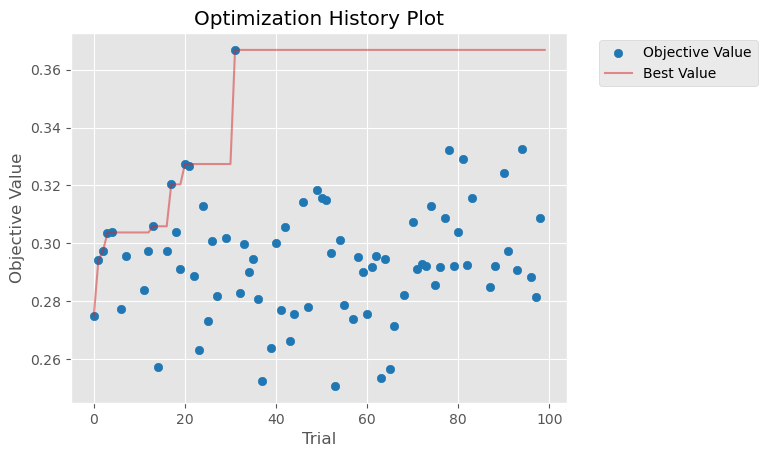

In [33]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-06-19 22:30:26,750] A new study created in memory with name: no-name-06b21499-8866-42aa-83e4-4ab97145ffb5
/tmp/ipykernel_190012/3414932042.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


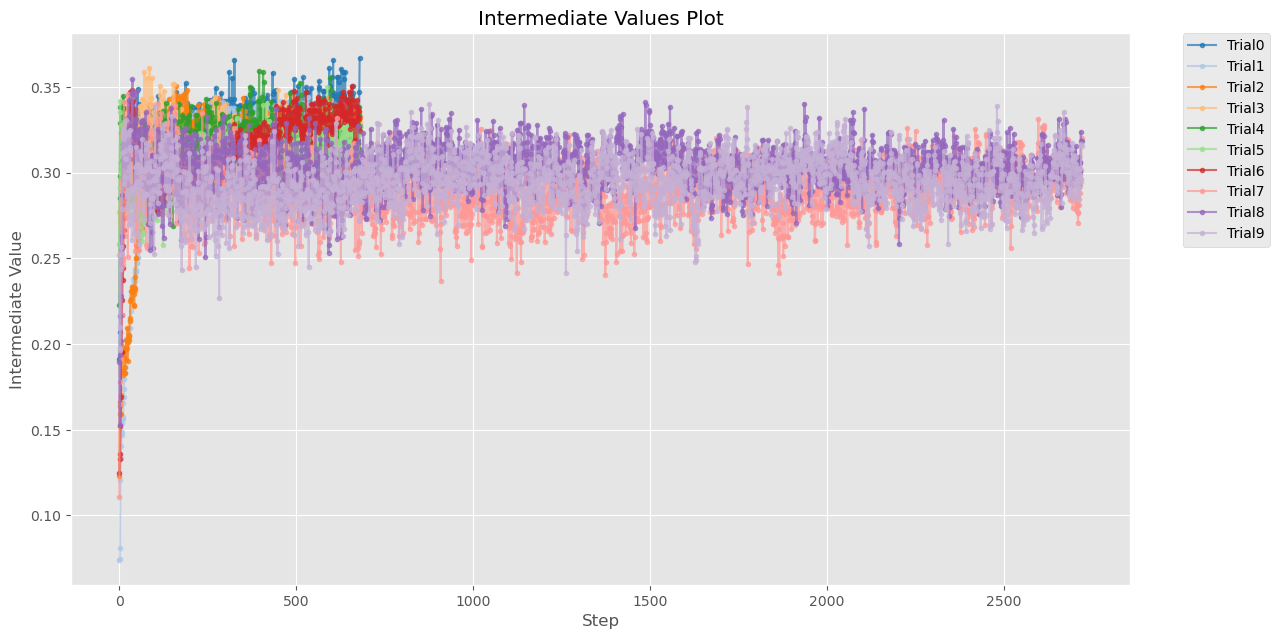

In [34]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value, reverse=True)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

/tmp/ipykernel_190012/2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


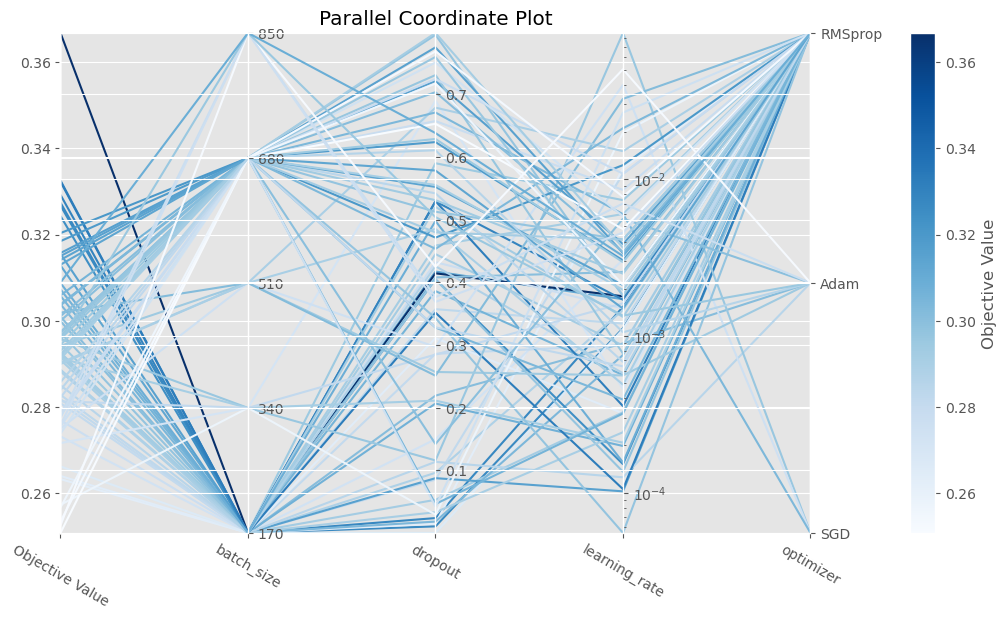

In [35]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

/tmp/ipykernel_190012/624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-06-19 22:30:27,849] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


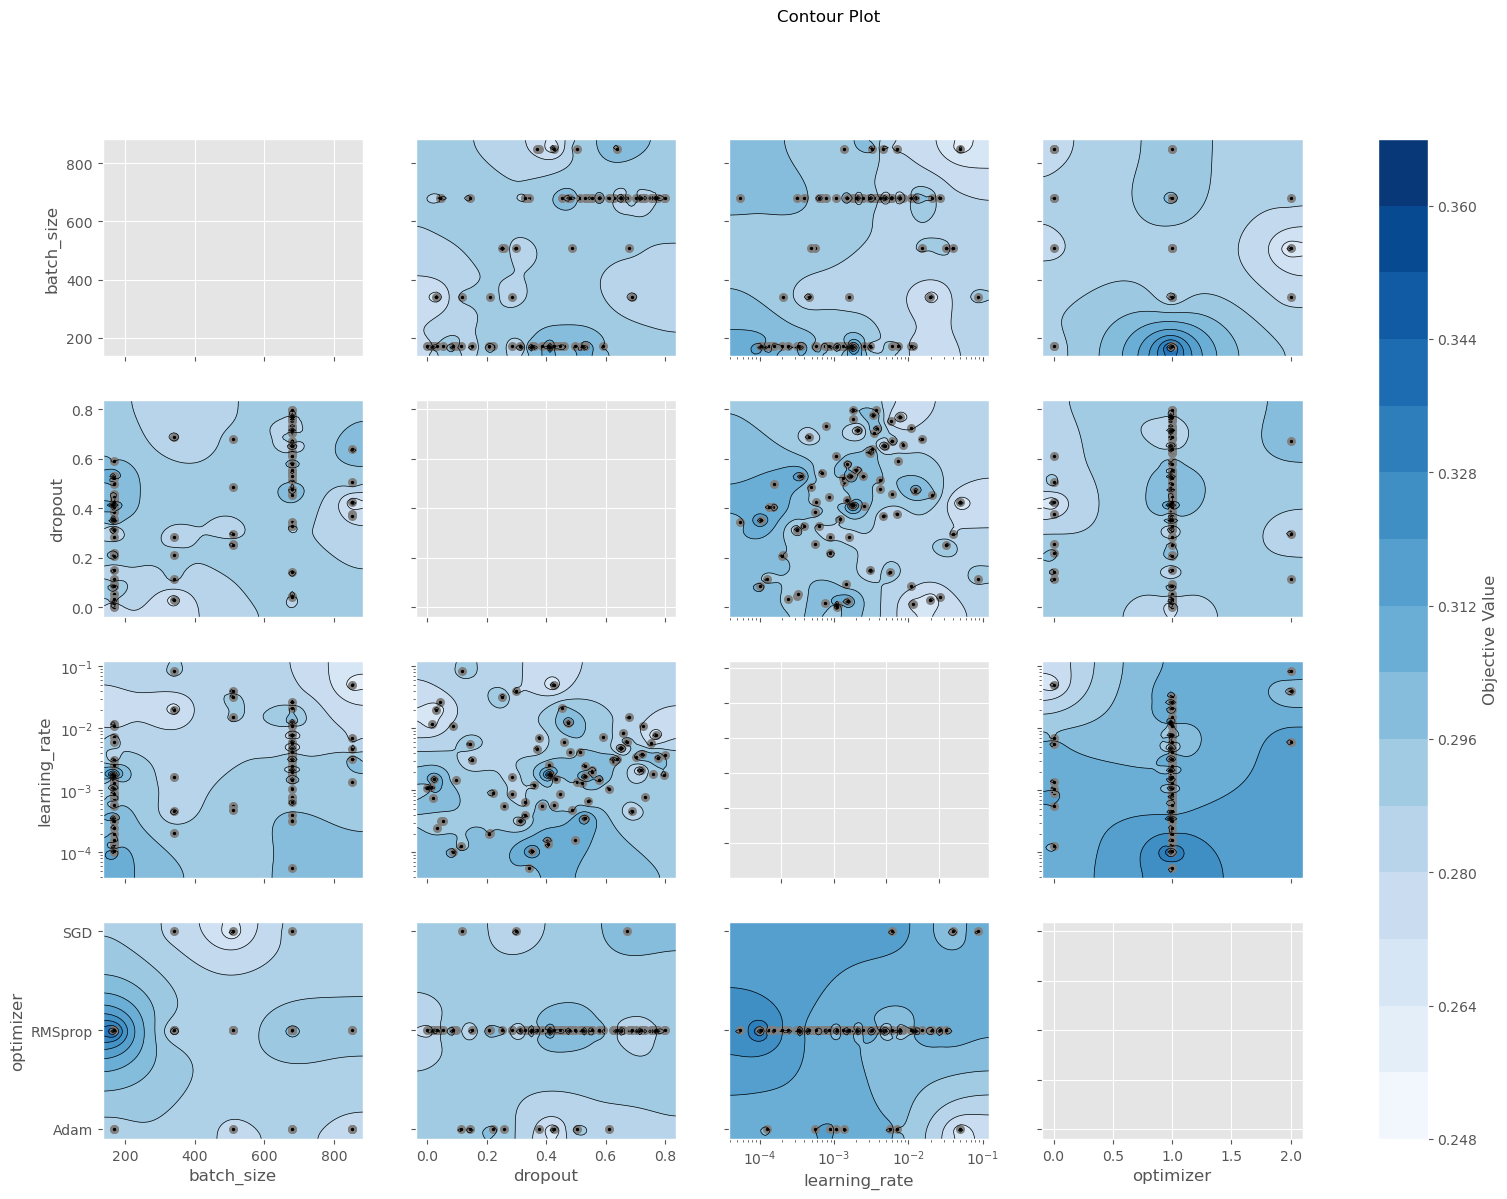

In [36]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

/tmp/ipykernel_190012/1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='learning_rate'>,
       <Axes: xlabel='optimizer'>], dtype=object)

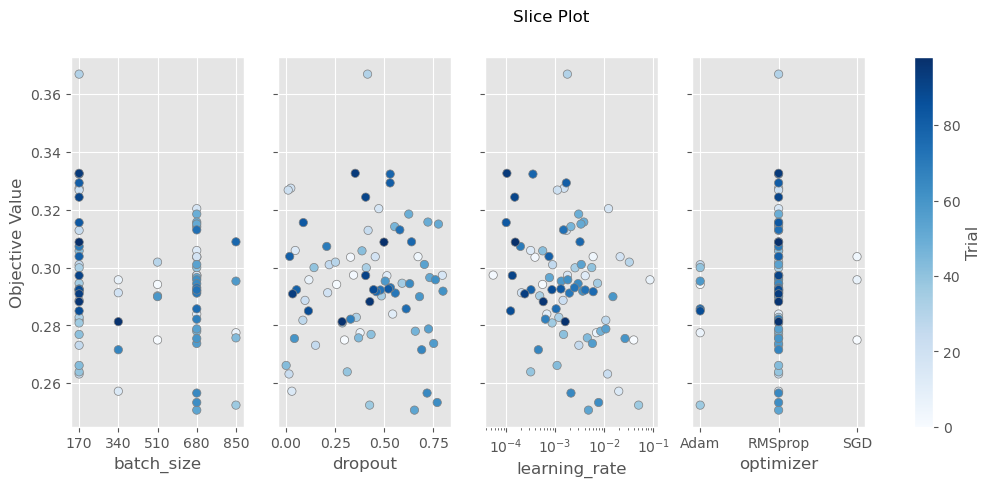

In [37]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

/tmp/ipykernel_190012/1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

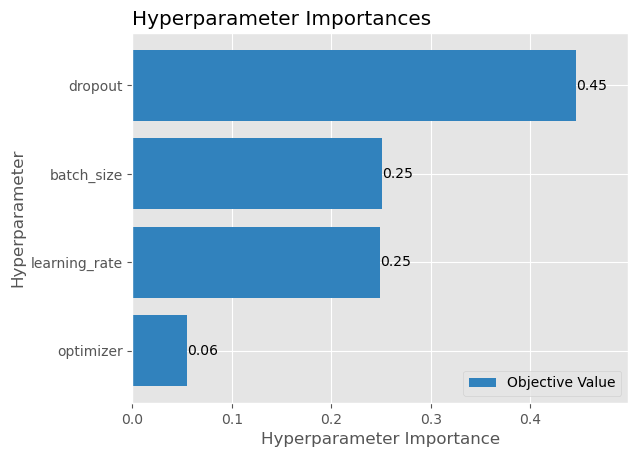

In [38]:
# Visualize parameter importances.
plot_param_importances(study)

/tmp/ipykernel_190012/3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

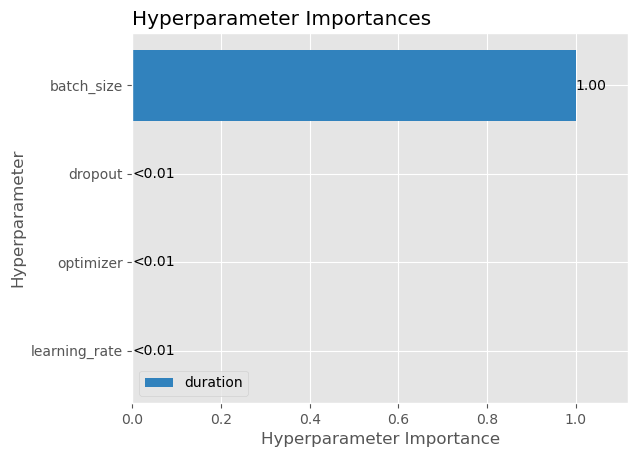

In [39]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

/tmp/ipykernel_190012/1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

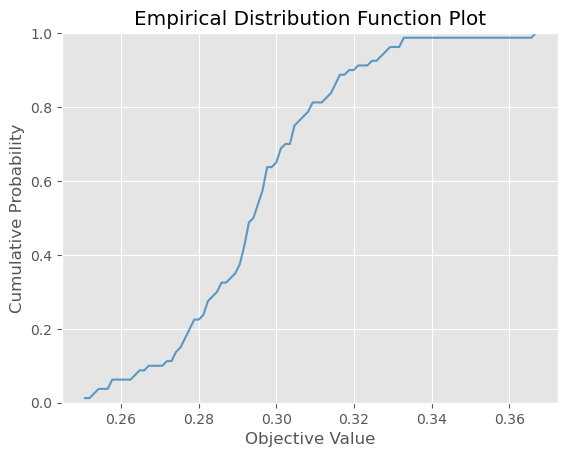

In [40]:
# Visualize empirical distribution function.
plot_edf(study)

/tmp/ipykernel_190012/1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-06-19 22:30:33,750] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


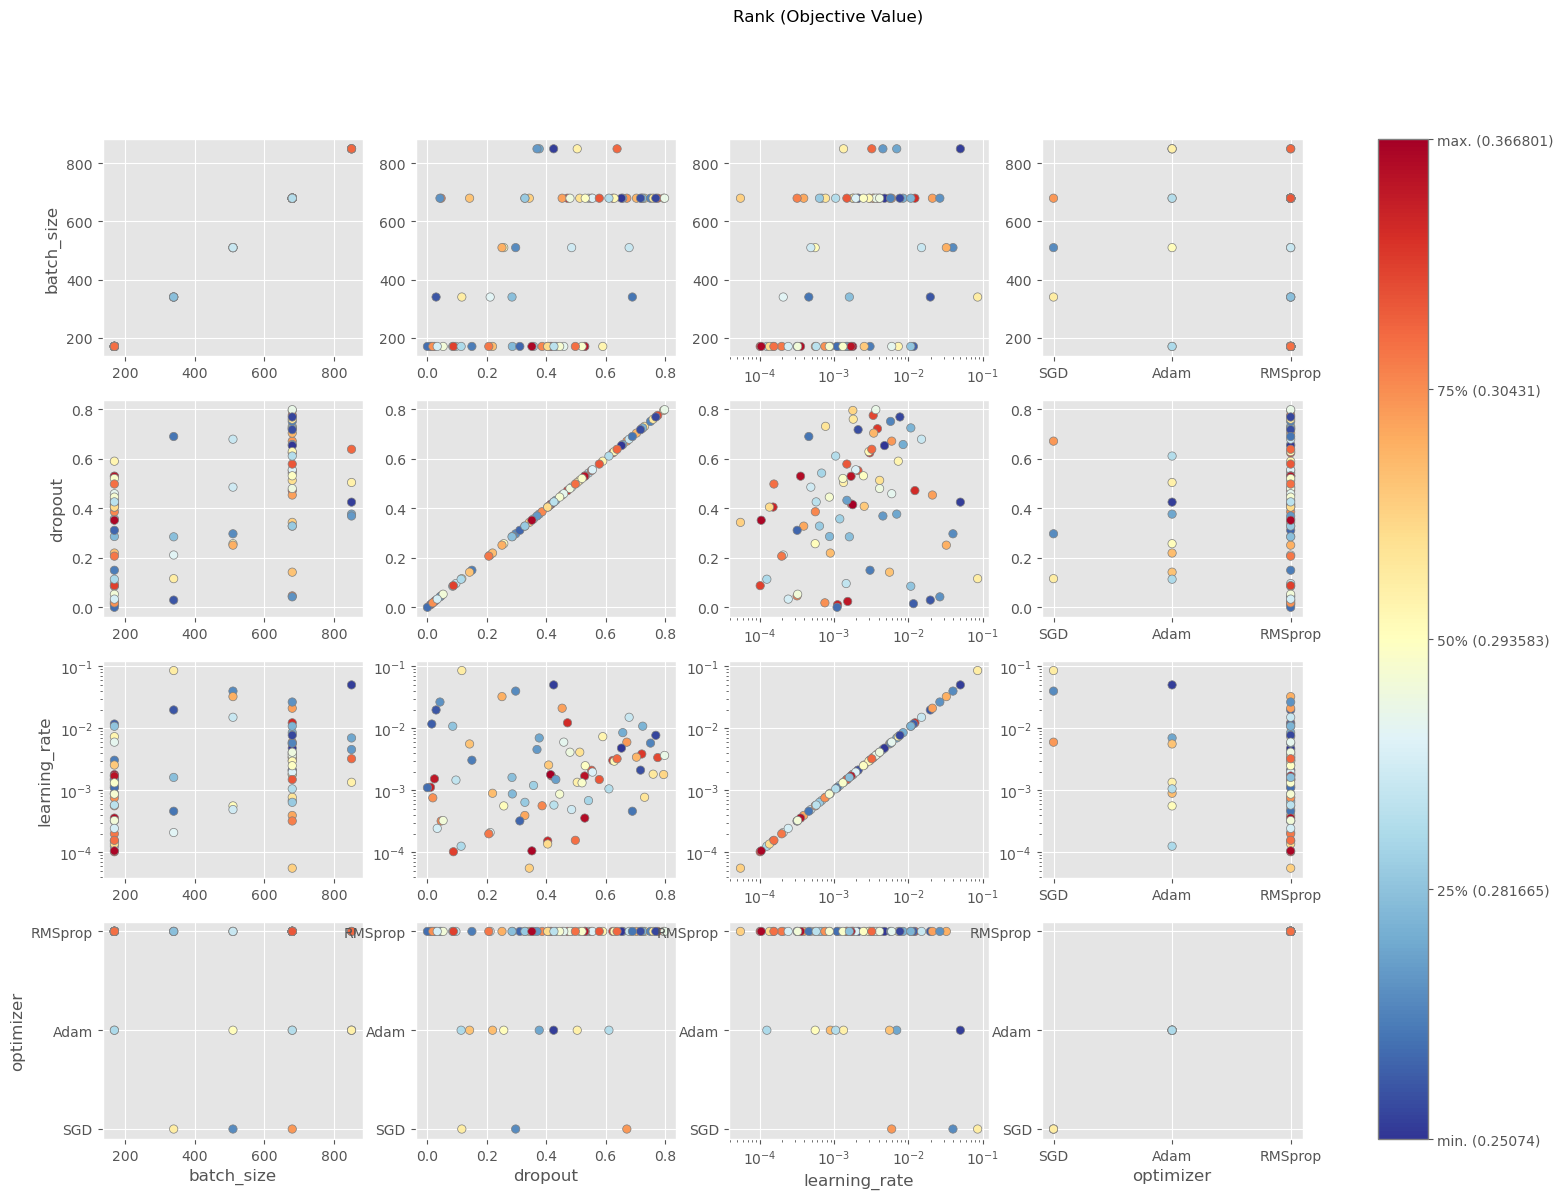

In [41]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

/tmp/ipykernel_190012/124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


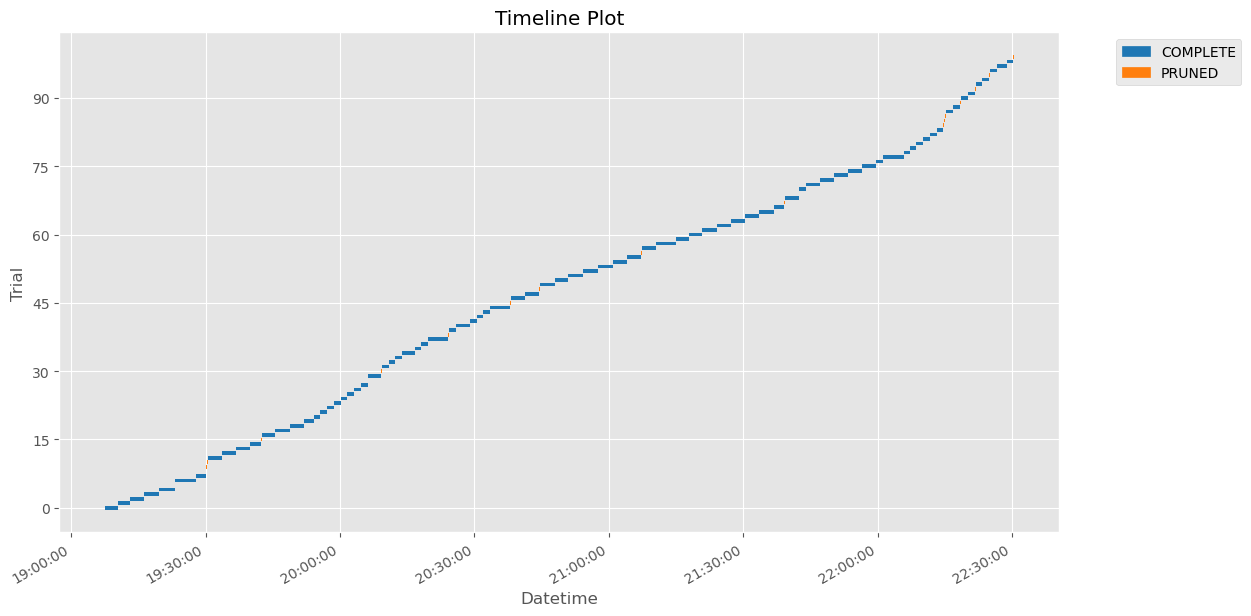

In [42]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)

# 3. ratio feature set

In [43]:
from sklearn.model_selection import StratifiedGroupKFold

baseline_rest_idxs = data_split_indices['ratio'][0]
baseline_val_idxs = data_split_indices['ratio'][1]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_ratio_ids for i in range(12)] # times 12 for each epoch

print(f'{len(ratio_graph_dataset) = }')
print(f'{len(baseline_rest_idxs) = }, {len(baseline_val_idxs) = }, total: {len(baseline_rest_idxs)+len(baseline_val_idxs)}')

X_traintest = [ratio_graph_dataset[i] for i in baseline_rest_idxs] 
X_val = [ratio_graph_dataset[i] for i in baseline_val_idxs]
Y_traintest =[ratio_y_list[i] for i in baseline_rest_idxs]
Y_val = [ratio_y_list[i] for i in baseline_val_idxs]
groups_traintest = [groups[i] for i in baseline_rest_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]

# now splitting the test and training data with seperate StratifiedGroupKFold
desired_test_ratio = 0.20
n_splits = int(1 / desired_test_ratio) # for some reason (?), n_splits also determines the proportion between train & test indices
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)  # should shuffle be true?

train_idxs, test_idxs = sgkf.split(X_traintest, Y_traintest, groups_traintest).__next__() # just take the first split
print(f'{len(X_traintest) = }, {len(X_val) = }')
print(f'{len(train_idxs) = }, {len(test_idxs) = }, total: {len(train_idxs)+len(test_idxs)}')

X_train = [X_traintest[i] for i in train_idxs] # X also includes y values, because they are stored in the Data object
X_test = [X_traintest[i] for i in test_idxs]
Y_train =[Y_traintest[i] for i in train_idxs]
Y_test = [Y_traintest[i] for i in test_idxs]

len(ratio_graph_dataset) = 2688
len(baseline_rest_idxs) = 2148, len(baseline_val_idxs) = 540, total: 2688
len(X_traintest) = 2148, len(X_val) = 540
len(train_idxs) = 1716, len(test_idxs) = 432, total: 2148


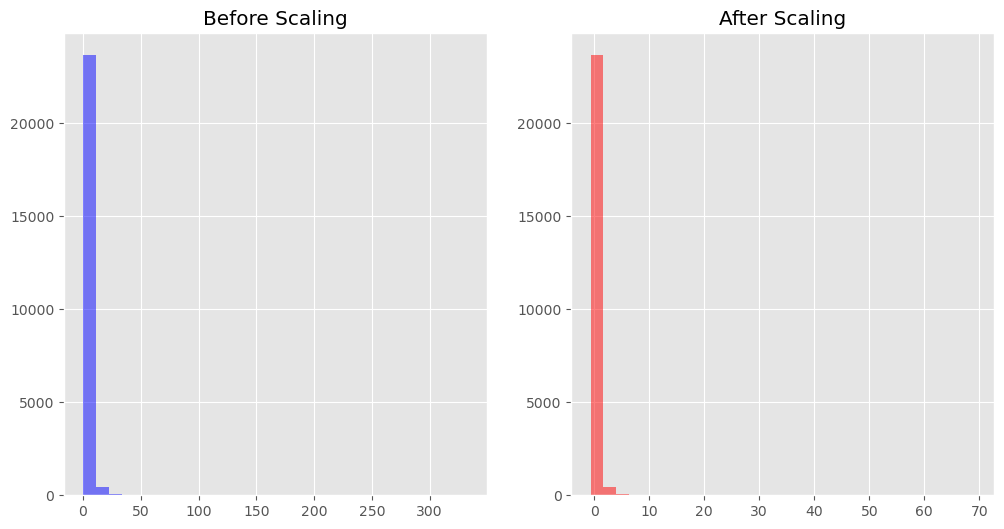

In [44]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val])) # fit on training and validation data


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

### Model: standard GCN

In [45]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import RichProgressBar
import logging
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", "Trying to infer the `batch_size` from an ambiguous collection.*")
torch.set_float32_matmul_precision('high')
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

def objective(trial):
    # Suggest values for the hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [170, 340, 510, 680, 850])
    dropout = trial.suggest_float('dropout', 0, 0.8)
    hyperparameters = dict(learning_rate=learning_rate, optimizer_name=optimizer_name, batch_size=batch_size, dropout=dropout)
    print(f'Tested parameters: {hyperparameters}')
    n_epochs = batch_size * 4 # vary training epochs based on batch size

    # Create the model
    model = GCN(learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout)

    

    # Create the PyTorch Lightning trainer
    trainer = Trainer(
        accelerator='gpu',
        devices=1,
        max_epochs=n_epochs,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_f1")],
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=True,
        enable_checkpointing=False
    )

    # Define the data loaders
    train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True,
                              drop_last=True) # , num_workers=0, persistent_workers=True
    val_loader = DataLoader(X_val, batch_size=len(X_val), shuffle=False,
                            drop_last=True) # , num_workers=0, persistent_workers=True

    # Log the hyperparameters
    trainer.logger.log_hyperparams(hyperparameters)

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Evaluate the model
    val_f1 = trainer.callback_metrics["val_f1"].item()

    return val_f1

study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=100))
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

df = study.trials_dataframe()
df.to_pickle('ratio_results_stand_GCN_trials.pkl')

[I 2024-06-19 22:30:37,355] A new study created in memory with name: no-name-38b0718c-81ef-4183-9dee-907b00aa3e55
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.0007621637781398205, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.5660701548895517}


[I 2024-06-19 22:32:48,908] Trial 0 finished with value: 0.23419800400733948 and parameters: {'learning_rate': 0.0007621637781398205, 'optimizer': 'SGD', 'batch_size': 340, 'dropout': 0.5660701548895517}. Best is trial 0 with value: 0.23419800400733948.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 1.7272296708666805e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.17532638803932638}


[I 2024-06-19 22:34:20,124] Trial 1 finished with value: 0.23929324746131897 and parameters: {'learning_rate': 1.7272296708666805e-05, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.17532638803932638}. Best is trial 1 with value: 0.23929324746131897.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.0026344838711600707, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.7122557150733908}


[I 2024-06-19 22:37:32,019] Trial 2 finished with value: 0.2288830727338791 and parameters: {'learning_rate': 0.0026344838711600707, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.7122557150733908}. Best is trial 1 with value: 0.23929324746131897.


Tested parameters: {'learning_rate': 0.00023776005528415342, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.1424266305275065}


[I 2024-06-19 22:40:42,821] Trial 3 finished with value: 0.27293458580970764 and parameters: {'learning_rate': 0.00023776005528415342, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.1424266305275065}. Best is trial 3 with value: 0.27293458580970764.


Tested parameters: {'learning_rate': 6.593650162188773e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.6069217748491631}


[I 2024-06-19 22:42:59,855] Trial 4 finished with value: 0.2776859402656555 and parameters: {'learning_rate': 6.593650162188773e-05, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.6069217748491631}. Best is trial 4 with value: 0.2776859402656555.


Tested parameters: {'learning_rate': 1.023229507390317e-05, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.1540688803477207}


[I 2024-06-19 22:43:06,726] Trial 5 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.01449783811179042, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.7060255013930001}


[I 2024-06-19 22:43:20,418] Trial 6 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0059922947873280305, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.3232383205731572}


[I 2024-06-19 22:44:50,930] Trial 7 finished with value: 0.22531025111675262 and parameters: {'learning_rate': 0.0059922947873280305, 'optimizer': 'Adam', 'batch_size': 170, 'dropout': 0.3232383205731572}. Best is trial 4 with value: 0.2776859402656555.
/home/tsmolders/.conda/envs/py3117/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Tested parameters: {'learning_rate': 0.020304618001333426, 'optimizer_name': 'Adam', 'batch_size': 510, 'dropout': 0.41226251034418626}


[I 2024-06-19 22:47:42,583] Trial 8 finished with value: 0.24333171546459198 and parameters: {'learning_rate': 0.020304618001333426, 'optimizer': 'Adam', 'batch_size': 510, 'dropout': 0.41226251034418626}. Best is trial 4 with value: 0.2776859402656555.


Tested parameters: {'learning_rate': 0.0015841203781662182, 'optimizer_name': 'SGD', 'batch_size': 170, 'dropout': 0.3690156066432888}


[I 2024-06-19 22:47:55,306] Trial 9 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00011125214884697804, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.5704040960931394}


[I 2024-06-19 22:48:04,895] Trial 10 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.000204399713901979, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.04309570027200016}


[I 2024-06-19 22:48:57,872] Trial 11 pruned. Trial was pruned at epoch 681.


Tested parameters: {'learning_rate': 0.00012524495224188793, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.5354094866448194}


[I 2024-06-19 22:49:59,098] Trial 12 pruned. Trial was pruned at epoch 630.


Tested parameters: {'learning_rate': 3.8934972877489985e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.7941760763634925}


[I 2024-06-19 22:50:06,856] Trial 13 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0004123784091194098, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.006962457088301038}


[I 2024-06-19 22:50:57,275] Trial 14 pruned. Trial was pruned at epoch 630.


Tested parameters: {'learning_rate': 0.07209480326322426, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.24683554091921306}


[I 2024-06-19 22:53:38,867] Trial 15 finished with value: 0.24944008886814117 and parameters: {'learning_rate': 0.07209480326322426, 'optimizer': 'SGD', 'batch_size': 510, 'dropout': 0.24683554091921306}. Best is trial 4 with value: 0.2776859402656555.


Tested parameters: {'learning_rate': 4.782578649878401e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.44609592519928404}


[I 2024-06-19 22:53:45,772] Trial 16 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00036602953651395146, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.48750723666142537}


[I 2024-06-19 22:55:59,647] Trial 17 finished with value: 0.2569999098777771 and parameters: {'learning_rate': 0.00036602953651395146, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.48750723666142537}. Best is trial 4 with value: 0.2776859402656555.


Tested parameters: {'learning_rate': 5.336210430719204e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.6455493837513413}


[I 2024-06-19 22:56:09,386] Trial 18 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0006215644797720208, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.10671326612127087}


[I 2024-06-19 22:56:16,308] Trial 19 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 2.1834513966113245e-05, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.2816630899879269}


[I 2024-06-19 22:56:24,537] Trial 20 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00031503409681099743, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.4806198167723623}


[I 2024-06-19 22:58:42,896] Trial 21 finished with value: 0.23892591893672943 and parameters: {'learning_rate': 0.00031503409681099743, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.4806198167723623}. Best is trial 4 with value: 0.2776859402656555.


Tested parameters: {'learning_rate': 0.00011659962872382943, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.4894376125344278}


[I 2024-06-19 22:58:52,981] Trial 22 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0002345398700506735, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.6275953919936204}


[I 2024-06-19 22:59:03,447] Trial 23 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0012191763154446986, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.3716036614071799}


[I 2024-06-19 23:01:18,484] Trial 24 finished with value: 0.253337025642395 and parameters: {'learning_rate': 0.0012191763154446986, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.3716036614071799}. Best is trial 4 with value: 0.2776859402656555.


Tested parameters: {'learning_rate': 0.0030952591079183352, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.2321636514350685}


[I 2024-06-19 23:03:36,200] Trial 25 pruned. Trial was pruned at epoch 1736.


Tested parameters: {'learning_rate': 8.42794347839529e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.6319042681236319}


[I 2024-06-19 23:03:43,469] Trial 26 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0004322465633540013, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.5150046493006831}


[I 2024-06-19 23:05:59,951] Trial 27 finished with value: 0.2718779444694519 and parameters: {'learning_rate': 0.0004322465633540013, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.5150046493006831}. Best is trial 4 with value: 0.2776859402656555.


Tested parameters: {'learning_rate': 0.00019138785779242948, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.7219020837918892}


[I 2024-06-19 23:06:09,941] Trial 28 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.000712452390094315, 'optimizer_name': 'SGD', 'batch_size': 340, 'dropout': 0.5579151184513697}


[I 2024-06-19 23:06:19,864] Trial 29 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0006814420012243862, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.5903667038751921}


[I 2024-06-19 23:06:26,669] Trial 30 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0004521556999091104, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.5121478705508075}


[I 2024-06-19 23:08:40,198] Trial 31 finished with value: 0.2389165163040161 and parameters: {'learning_rate': 0.0004521556999091104, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.5121478705508075}. Best is trial 4 with value: 0.2776859402656555.


Tested parameters: {'learning_rate': 2.765146798378965e-05, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.45221276121940296}


[I 2024-06-19 23:08:50,182] Trial 32 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0016777674678439291, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.40491477293907435}


[I 2024-06-19 23:11:11,421] Trial 33 finished with value: 0.24031701683998108 and parameters: {'learning_rate': 0.0016777674678439291, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.40491477293907435}. Best is trial 4 with value: 0.2776859402656555.


Tested parameters: {'learning_rate': 0.00030636418884747444, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.6728466559348569}


[I 2024-06-19 23:11:23,261] Trial 34 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 1.4592210428176891e-05, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.3195090881220558}


[I 2024-06-19 23:11:32,398] Trial 35 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 6.80422870078014e-05, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.583897615499185}


[I 2024-06-19 23:11:47,460] Trial 36 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.002952730758694132, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.7646084470122697}


[I 2024-06-19 23:14:31,770] Trial 37 finished with value: 0.24541518092155457 and parameters: {'learning_rate': 0.002952730758694132, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.7646084470122697}. Best is trial 4 with value: 0.2776859402656555.


Tested parameters: {'learning_rate': 0.00477065351263674, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.18195471915111272}


[I 2024-06-19 23:16:50,384] Trial 38 finished with value: 0.22331736981868744 and parameters: {'learning_rate': 0.00477065351263674, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.18195471915111272}. Best is trial 4 with value: 0.2776859402656555.


Tested parameters: {'learning_rate': 0.00015875633309435453, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.437370040411278}


[I 2024-06-19 23:18:20,873] Trial 39 finished with value: 0.2114938199520111 and parameters: {'learning_rate': 0.00015875633309435453, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.437370040411278}. Best is trial 4 with value: 0.2776859402656555.


Tested parameters: {'learning_rate': 0.0010815702211713727, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.5195545728178201}


[I 2024-06-19 23:20:36,668] Trial 40 pruned. Trial was pruned at epoch 1736.


Tested parameters: {'learning_rate': 0.0013203079715775013, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.37509496546423265}


[I 2024-06-19 23:22:59,401] Trial 41 finished with value: 0.24577629566192627 and parameters: {'learning_rate': 0.0013203079715775013, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.37509496546423265}. Best is trial 4 with value: 0.2776859402656555.


Tested parameters: {'learning_rate': 0.0004686191098212069, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.11590794628433665}


[I 2024-06-19 23:23:12,552] Trial 42 pruned. Trial was pruned at epoch 110.


Tested parameters: {'learning_rate': 0.010074444526691689, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.3396678565380942}


[I 2024-06-19 23:25:32,838] Trial 43 finished with value: 0.26003003120422363 and parameters: {'learning_rate': 0.010074444526691689, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.3396678565380942}. Best is trial 4 with value: 0.2776859402656555.


Tested parameters: {'learning_rate': 0.028103757760133765, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.33609540377438735}


[I 2024-06-19 23:25:42,576] Trial 44 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.008663466839602653, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.47957289691617994}


[I 2024-06-19 23:29:08,483] Trial 45 finished with value: 0.2858491539955139 and parameters: {'learning_rate': 0.008663466839602653, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.47957289691617994}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.009683988704425633, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.21270663411019086}


[I 2024-06-19 23:31:38,325] Trial 46 pruned. Trial was pruned at epoch 2124.


Tested parameters: {'learning_rate': 0.050623571584077674, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.06525529295040147}


[I 2024-06-19 23:31:45,164] Trial 47 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.007511943495951531, 'optimizer_name': 'SGD', 'batch_size': 680, 'dropout': 0.540805660912251}


[I 2024-06-19 23:31:51,914] Trial 48 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.020388922252122046, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.28703649867269565}


[I 2024-06-19 23:35:02,658] Trial 49 finished with value: 0.2635182738304138 and parameters: {'learning_rate': 0.020388922252122046, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.28703649867269565}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.04135008154717704, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.28746989034304266}


[I 2024-06-19 23:35:09,588] Trial 50 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.014627685760632033, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.17505173811061037}


[I 2024-06-19 23:38:16,614] Trial 51 finished with value: 0.23120088875293732 and parameters: {'learning_rate': 0.014627685760632033, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.17505173811061037}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.020552842844954025, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.27995320429193343}


[I 2024-06-19 23:41:24,323] Trial 52 finished with value: 0.22151657938957214 and parameters: {'learning_rate': 0.020552842844954025, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.27995320429193343}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.011432607406121042, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.34060088034973934}


[I 2024-06-19 23:44:41,553] Trial 53 finished with value: 0.26674580574035645 and parameters: {'learning_rate': 0.011432607406121042, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.34060088034973934}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.08444884743075974, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.126493677187071}


[I 2024-06-19 23:44:48,431] Trial 54 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.02808962610962897, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.43886706513762425}


[I 2024-06-19 23:44:55,720] Trial 55 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.004883037983479283, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.6045069709855154}


[I 2024-06-19 23:48:03,663] Trial 56 finished with value: 0.2758731245994568 and parameters: {'learning_rate': 0.004883037983479283, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.6045069709855154}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.005766896900727373, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.6109903013349314}


[I 2024-06-19 23:51:11,845] Trial 57 finished with value: 0.2801554799079895 and parameters: {'learning_rate': 0.005766896900727373, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.6109903013349314}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.004666096290549475, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.5985569837620581}


[I 2024-06-19 23:51:19,847] Trial 58 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0020968249035444664, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.6835807984225107}


[I 2024-06-19 23:55:52,434] Trial 59 finished with value: 0.24090315401554108 and parameters: {'learning_rate': 0.0020968249035444664, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.6835807984225107}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.004640111216224895, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.6160617653620795}


[I 2024-06-19 23:59:19,562] Trial 60 finished with value: 0.2761962413787842 and parameters: {'learning_rate': 0.004640111216224895, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.6160617653620795}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.004556944407399118, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.611250898803008}


[I 2024-06-20 00:02:29,297] Trial 61 finished with value: 0.234864741563797 and parameters: {'learning_rate': 0.004556944407399118, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.611250898803008}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.006221229642083701, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.6443785050259451}


[I 2024-06-20 00:05:41,106] Trial 62 finished with value: 0.2525274157524109 and parameters: {'learning_rate': 0.006221229642083701, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.6443785050259451}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.0024543897466450305, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.5535553050520469}


[I 2024-06-20 00:08:51,357] Trial 63 finished with value: 0.2709499001502991 and parameters: {'learning_rate': 0.0024543897466450305, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.5535553050520469}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.003261105079624301, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.7329795269570419}


[I 2024-06-20 00:12:04,627] Trial 64 finished with value: 0.2553809583187103 and parameters: {'learning_rate': 0.003261105079624301, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.7329795269570419}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 8.795781656130887e-05, 'optimizer_name': 'Adam', 'batch_size': 170, 'dropout': 0.6785114968466583}


[I 2024-06-20 00:12:17,619] Trial 65 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0008638946453769427, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.5138932557613587}


[I 2024-06-20 00:15:29,977] Trial 66 finished with value: 0.2654121518135071 and parameters: {'learning_rate': 0.0008638946453769427, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.5138932557613587}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.007359409201273898, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.47274817904825495}


[I 2024-06-20 00:18:49,751] Trial 67 finished with value: 0.24325352907180786 and parameters: {'learning_rate': 0.007359409201273898, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.47274817904825495}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.00027136641615892936, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.5862948739627597}


[I 2024-06-20 00:22:01,091] Trial 68 finished with value: 0.243854358792305 and parameters: {'learning_rate': 0.00027136641615892936, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.5862948739627597}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.0001612424231144912, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.6144710510197893}


[I 2024-06-20 00:22:09,050] Trial 69 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 3.954006960205887e-05, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.5604505351523461}


[I 2024-06-20 00:22:16,842] Trial 70 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.0018191319759247489, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.5492681324306146}


[I 2024-06-20 00:25:26,628] Trial 71 finished with value: 0.25904572010040283 and parameters: {'learning_rate': 0.0018191319759247489, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.5492681324306146}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.003069863658642835, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.657336505281724}


[I 2024-06-20 00:28:39,220] Trial 72 finished with value: 0.2396925389766693 and parameters: {'learning_rate': 0.003069863658642835, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.657336505281724}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.002265193018105999, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.5716110676099506}


[I 2024-06-20 00:31:57,606] Trial 73 finished with value: 0.26963040232658386 and parameters: {'learning_rate': 0.002265193018105999, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.5716110676099506}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.0038037168143228617, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.4996158097514769}


[I 2024-06-20 00:35:11,888] Trial 74 finished with value: 0.22441524267196655 and parameters: {'learning_rate': 0.0038037168143228617, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.4996158097514769}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.0005549307534850225, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.6221961827729575}


[I 2024-06-20 00:35:19,183] Trial 75 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.005955893760696669, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.5282295320335779}


[I 2024-06-20 00:36:48,723] Trial 76 finished with value: 0.22518187761306763 and parameters: {'learning_rate': 0.005955893760696669, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.5282295320335779}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.0024361585810809146, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.7048466383258298}


[I 2024-06-20 00:39:57,414] Trial 77 finished with value: 0.24172727763652802 and parameters: {'learning_rate': 0.0024361585810809146, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.7048466383258298}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.014093219166854338, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.422939429397829}


[I 2024-06-20 00:43:11,847] Trial 78 finished with value: 0.2408735156059265 and parameters: {'learning_rate': 0.014093219166854338, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.422939429397829}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.001455138751447531, 'optimizer_name': 'RMSprop', 'batch_size': 680, 'dropout': 0.5644590260447517}


[I 2024-06-20 00:46:27,349] Trial 79 finished with value: 0.2612650394439697 and parameters: {'learning_rate': 0.001455138751447531, 'optimizer': 'RMSprop', 'batch_size': 680, 'dropout': 0.5644590260447517}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.00803588301004684, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.4639698858732757}


[I 2024-06-20 00:48:40,782] Trial 80 finished with value: 0.22743834555149078 and parameters: {'learning_rate': 0.00803588301004684, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.4639698858732757}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.0021266958487821752, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.5783396883142625}


[I 2024-06-20 00:51:55,327] Trial 81 finished with value: 0.2605888843536377 and parameters: {'learning_rate': 0.0021266958487821752, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.5783396883142625}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.005963749902974486, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.6051272310880312}


[I 2024-06-20 00:55:23,083] Trial 82 finished with value: 0.268754780292511 and parameters: {'learning_rate': 0.005963749902974486, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.6051272310880312}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.0009182523230381604, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.6422948567402295}


[I 2024-06-20 00:55:30,007] Trial 83 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.002525031884144739, 'optimizer_name': 'Adam', 'batch_size': 680, 'dropout': 0.5390303119406848}


[I 2024-06-20 00:58:46,732] Trial 84 finished with value: 0.2541351318359375 and parameters: {'learning_rate': 0.002525031884144739, 'optimizer': 'Adam', 'batch_size': 680, 'dropout': 0.5390303119406848}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.003727711270494866, 'optimizer_name': 'Adam', 'batch_size': 510, 'dropout': 0.49569647064985334}


[I 2024-06-20 01:01:31,143] Trial 85 finished with value: 0.2720531225204468 and parameters: {'learning_rate': 0.003727711270494866, 'optimizer': 'Adam', 'batch_size': 510, 'dropout': 0.49569647064985334}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.003952412612497196, 'optimizer_name': 'Adam', 'batch_size': 510, 'dropout': 0.5030252254692066}


[I 2024-06-20 01:04:13,748] Trial 86 finished with value: 0.25266799330711365 and parameters: {'learning_rate': 0.003952412612497196, 'optimizer': 'Adam', 'batch_size': 510, 'dropout': 0.5030252254692066}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.003927282150805756, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.4843996283134734}


[I 2024-06-20 01:07:06,885] Trial 87 finished with value: 0.2724400460720062 and parameters: {'learning_rate': 0.003927282150805756, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.4843996283134734}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.011098904071653516, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.42153151078300755}


[I 2024-06-20 01:09:50,451] Trial 88 finished with value: 0.24906574189662933 and parameters: {'learning_rate': 0.011098904071653516, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.42153151078300755}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.005222620942356901, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.4787707783869671}


[I 2024-06-20 01:12:41,649] Trial 89 finished with value: 0.23450438678264618 and parameters: {'learning_rate': 0.005222620942356901, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.4787707783869671}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 2.8240525939025032e-05, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.39736027134474095}


[I 2024-06-20 01:12:49,515] Trial 90 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00887680293078875, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.5277241829082405}


[I 2024-06-20 01:15:37,620] Trial 91 finished with value: 0.2626839280128479 and parameters: {'learning_rate': 0.00887680293078875, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.5277241829082405}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.003722589396421881, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.49379213496349966}


[I 2024-06-20 01:18:27,041] Trial 92 finished with value: 0.21731984615325928 and parameters: {'learning_rate': 0.003722589396421881, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.49379213496349966}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.0003705316069891364, 'optimizer_name': 'SGD', 'batch_size': 510, 'dropout': 0.5524014851449437}


[I 2024-06-20 01:18:35,317] Trial 93 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.007003451589812101, 'optimizer_name': 'RMSprop', 'batch_size': 340, 'dropout': 0.4647194941768117}


[I 2024-06-20 01:20:52,285] Trial 94 finished with value: 0.24258345365524292 and parameters: {'learning_rate': 0.007003451589812101, 'optimizer': 'RMSprop', 'batch_size': 340, 'dropout': 0.4647194941768117}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 1.0925822538212319e-05, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.5943929195024985}


[I 2024-06-20 01:21:00,204] Trial 95 pruned. Trial was pruned at epoch 100.


Tested parameters: {'learning_rate': 0.00431985664582853, 'optimizer_name': 'RMSprop', 'batch_size': 850, 'dropout': 0.6633949810704345}


[I 2024-06-20 01:25:37,764] Trial 96 finished with value: 0.23341940343379974 and parameters: {'learning_rate': 0.00431985664582853, 'optimizer': 'RMSprop', 'batch_size': 850, 'dropout': 0.6633949810704345}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.013963989732487537, 'optimizer_name': 'Adam', 'batch_size': 340, 'dropout': 0.628589189971461}


[I 2024-06-20 01:27:56,559] Trial 97 finished with value: 0.24997204542160034 and parameters: {'learning_rate': 0.013963989732487537, 'optimizer': 'Adam', 'batch_size': 340, 'dropout': 0.628589189971461}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 5.737918888701638e-05, 'optimizer_name': 'RMSprop', 'batch_size': 170, 'dropout': 0.5155048019777811}


[I 2024-06-20 01:29:31,121] Trial 98 finished with value: 0.2688494920730591 and parameters: {'learning_rate': 5.737918888701638e-05, 'optimizer': 'RMSprop', 'batch_size': 170, 'dropout': 0.5155048019777811}. Best is trial 45 with value: 0.2858491539955139.


Tested parameters: {'learning_rate': 0.0016363934768755131, 'optimizer_name': 'RMSprop', 'batch_size': 510, 'dropout': 0.0019926809173226867}


[I 2024-06-20 01:32:17,221] Trial 99 finished with value: 0.22830764949321747 and parameters: {'learning_rate': 0.0016363934768755131, 'optimizer': 'RMSprop', 'batch_size': 510, 'dropout': 0.0019926809173226867}. Best is trial 45 with value: 0.2858491539955139.


Best trial:
  Value: 0.2858491539955139
  Params: 
    learning_rate: 0.008663466839602653
    optimizer: RMSprop
    batch_size: 680
    dropout: 0.47957289691617994


In [46]:
df_trials = pd.read_pickle('ratio_results_stand_GCN_trials.pkl')
df_trials.sort_values('value', ascending=False).head(10)

number     value             datetime_start          datetime_complete  \
45      45  0.285849 2024-06-19 23:25:42.577081 2024-06-19 23:29:08.480480   
57      57  0.280155 2024-06-19 23:48:03.665823 2024-06-19 23:51:11.841666   
4        4  0.277686 2024-06-19 22:40:42.822861 2024-06-19 22:42:59.853272   
60      60  0.276196 2024-06-19 23:55:52.436487 2024-06-19 23:59:19.559449   
56      56  0.275873 2024-06-19 23:44:55.721234 2024-06-19 23:48:03.659524   
3        3  0.272935 2024-06-19 22:37:32.019834 2024-06-19 22:40:42.817911   
87      87  0.272440 2024-06-20 01:04:13.749019 2024-06-20 01:07:06.882523   
85      85  0.272053 2024-06-20 00:58:46.734271 2024-06-20 01:01:31.140181   
27      27  0.271878 2024-06-19 23:03:43.470093 2024-06-19 23:05:59.950157   
63      63  0.270950 2024-06-20 00:05:41.107473 2024-06-20 00:08:51.353867   

                 duration  params_batch_size  params_dropout  \
45 0 days 00:03:25.903399                680        0.479573   
57 0 days 00:03:08.175843                680        0.610990   
4  0 days 00:02:17.030411                340        0.606922   
60 0 days 00:03:27.122962                680        0.616062   
56 0 days 00:03:07.938290                680        0.604507   
3  0 days 00:03:10.798077                680        0.142427   
87 0 days 00:02:53.133504                510        0.484400   
85 0 days 00:02:44.405910                510        0.495696   
27 0 days 00:02:16.480064                340        0.515005   
63 0 days 00:03:10.246394                680        0.553555   

    params_learning_rate params_optimizer     state  
45              0.008663          RMSprop  COMPLETE  
57              0.005767          RMSprop  COMPLETE  
4               0.000066          RMSprop  COMPLETE  
60              0.004640             Adam  COMPLETE  
56              0.004883          RMSprop  COMPLETE  
3               0.000238          RMSprop  COMPLETE  
87              0.003927          RMSprop  COMPLETE  
85              0.003728             Adam  COMPLETE  
27              0.000432          RMSprop  COMPLETE  
63              0.002454             Adam  COMPLETE

#### Visualizations

/tmp/ipykernel_190012/1755039964.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

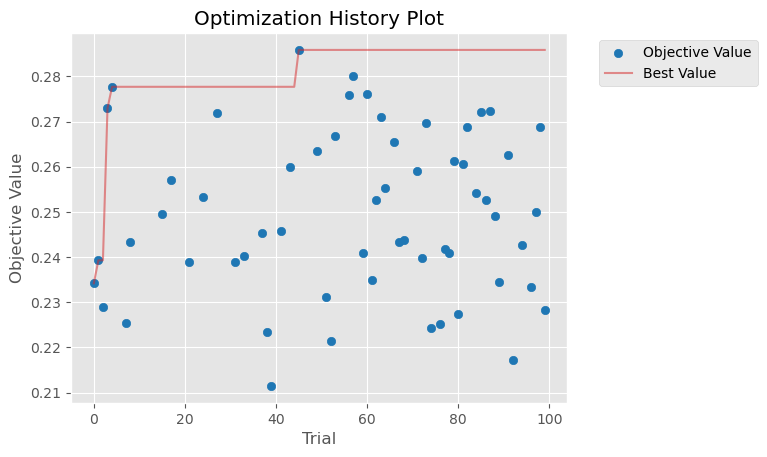

In [47]:
# Visualize the optimization history
plot_optimization_history(study)

[I 2024-06-20 01:32:17,627] A new study created in memory with name: no-name-0df692da-d2a4-432c-898d-1ec9ca03ccb8
/tmp/ipykernel_190012/3414932042.py:7: ExperimentalWarning: plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.
  plot_intermediate_values(plotted_study)


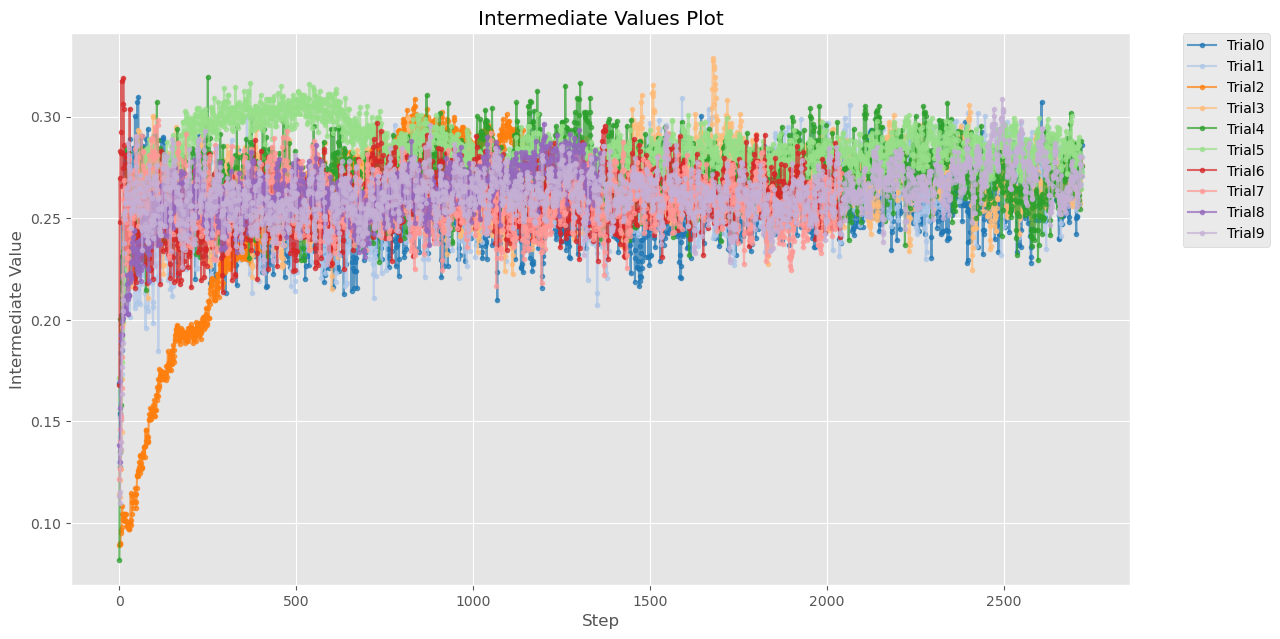

In [48]:
# Visualize the learning curves of the best 10 trials
trials = study.trials
plotted_trials = sorted(trials, key=lambda t: t.value, reverse=True)[:10]
plotted_study = optuna.create_study()
for trial in plotted_trials:
    plotted_study.add_trial(trial)
plot_intermediate_values(plotted_study)
set_size(10, 5)

/tmp/ipykernel_190012/2919792376.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  plot_parallel_coordinate(study)


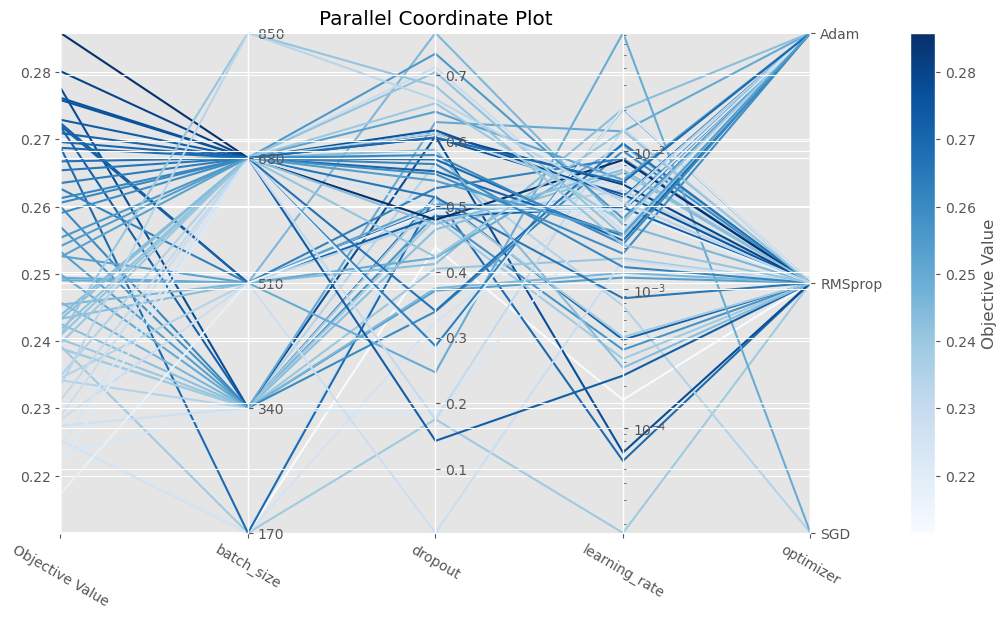

In [49]:
# Visualize high-dimensional parameter relationships.
plot_parallel_coordinate(study)
set_size(10, 5)

/tmp/ipykernel_190012/624402143.py:2: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  plot_contour(study)
[W 2024-06-20 01:32:18,792] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


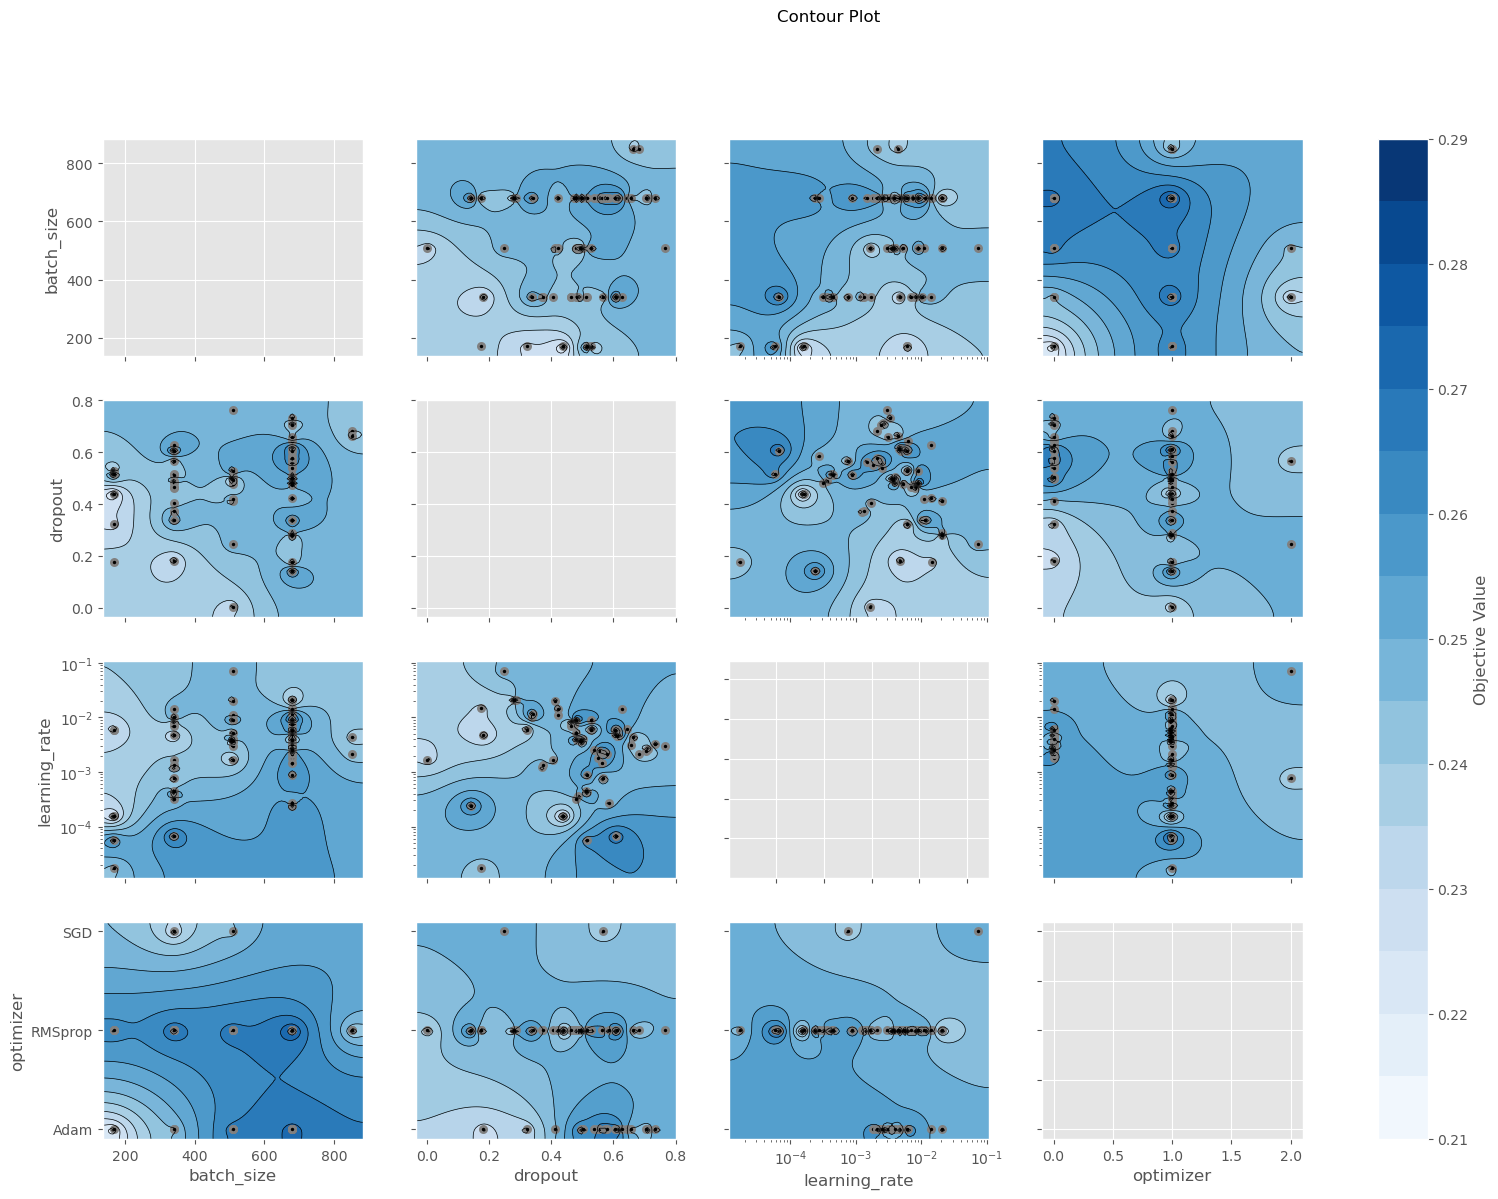

In [50]:
# Visualize hyperparameter relationships
plot_contour(study)
set_size(15, 10)

/tmp/ipykernel_190012/1888575690.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(study)


array([<Axes: xlabel='batch_size', ylabel='Objective Value'>,
       <Axes: xlabel='dropout'>, <Axes: xlabel='learning_rate'>,
       <Axes: xlabel='optimizer'>], dtype=object)

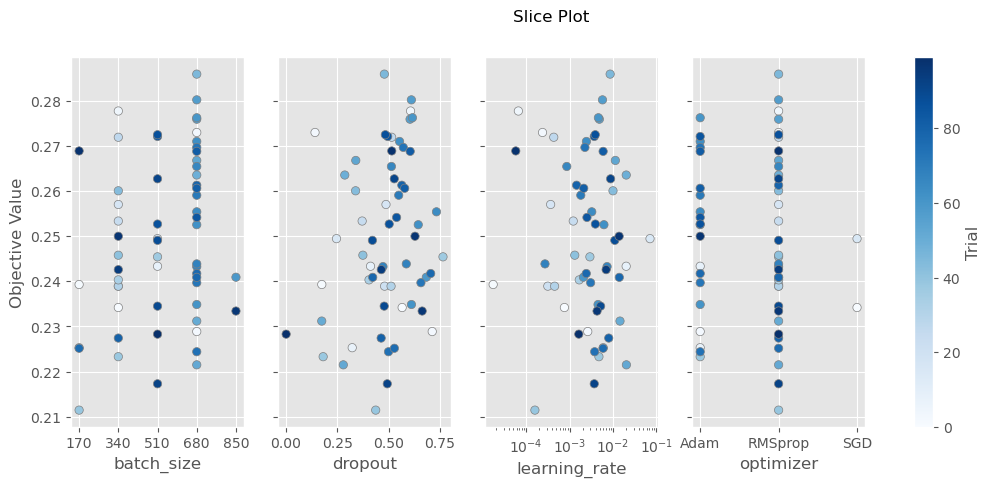

In [51]:
# Visualize individual hyperparameters as slice plot
plot_slice(study)

/tmp/ipykernel_190012/1473508994.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

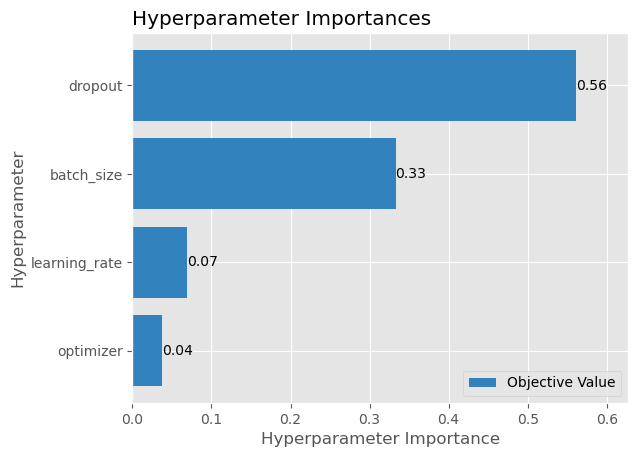

In [52]:
# Visualize parameter importances.
plot_param_importances(study)

/tmp/ipykernel_190012/3113371256.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

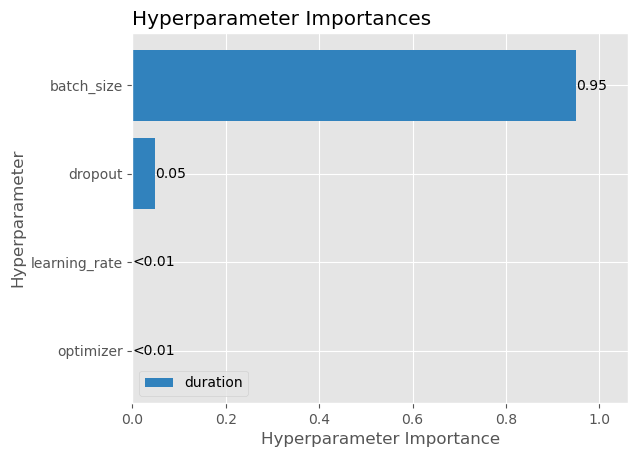

In [53]:
# Learn which hyperparameters are affecting the trial duration with hyperparameter importance.
plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

/tmp/ipykernel_190012/1828777839.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  plot_edf(study)


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

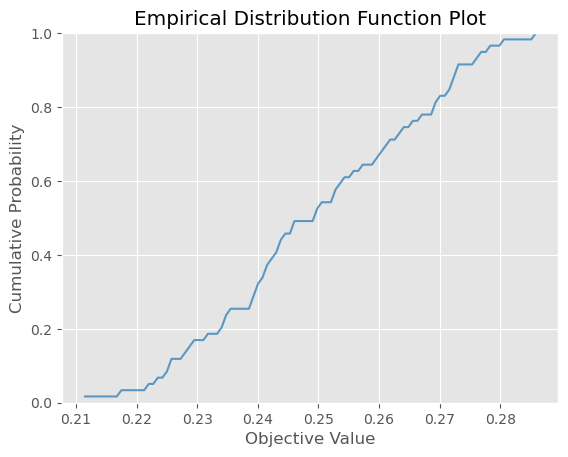

In [54]:
# Visualize empirical distribution function.
plot_edf(study)

/tmp/ipykernel_190012/1172520691.py:2: ExperimentalWarning: plot_rank is experimental (supported from v3.2.0). The interface can change in the future.
  plot_rank(study)
[W 2024-06-20 01:32:24,497] Output figures of this Matplotlib-based `plot_rank` function would be different from those of the Plotly-based `plot_rank`.


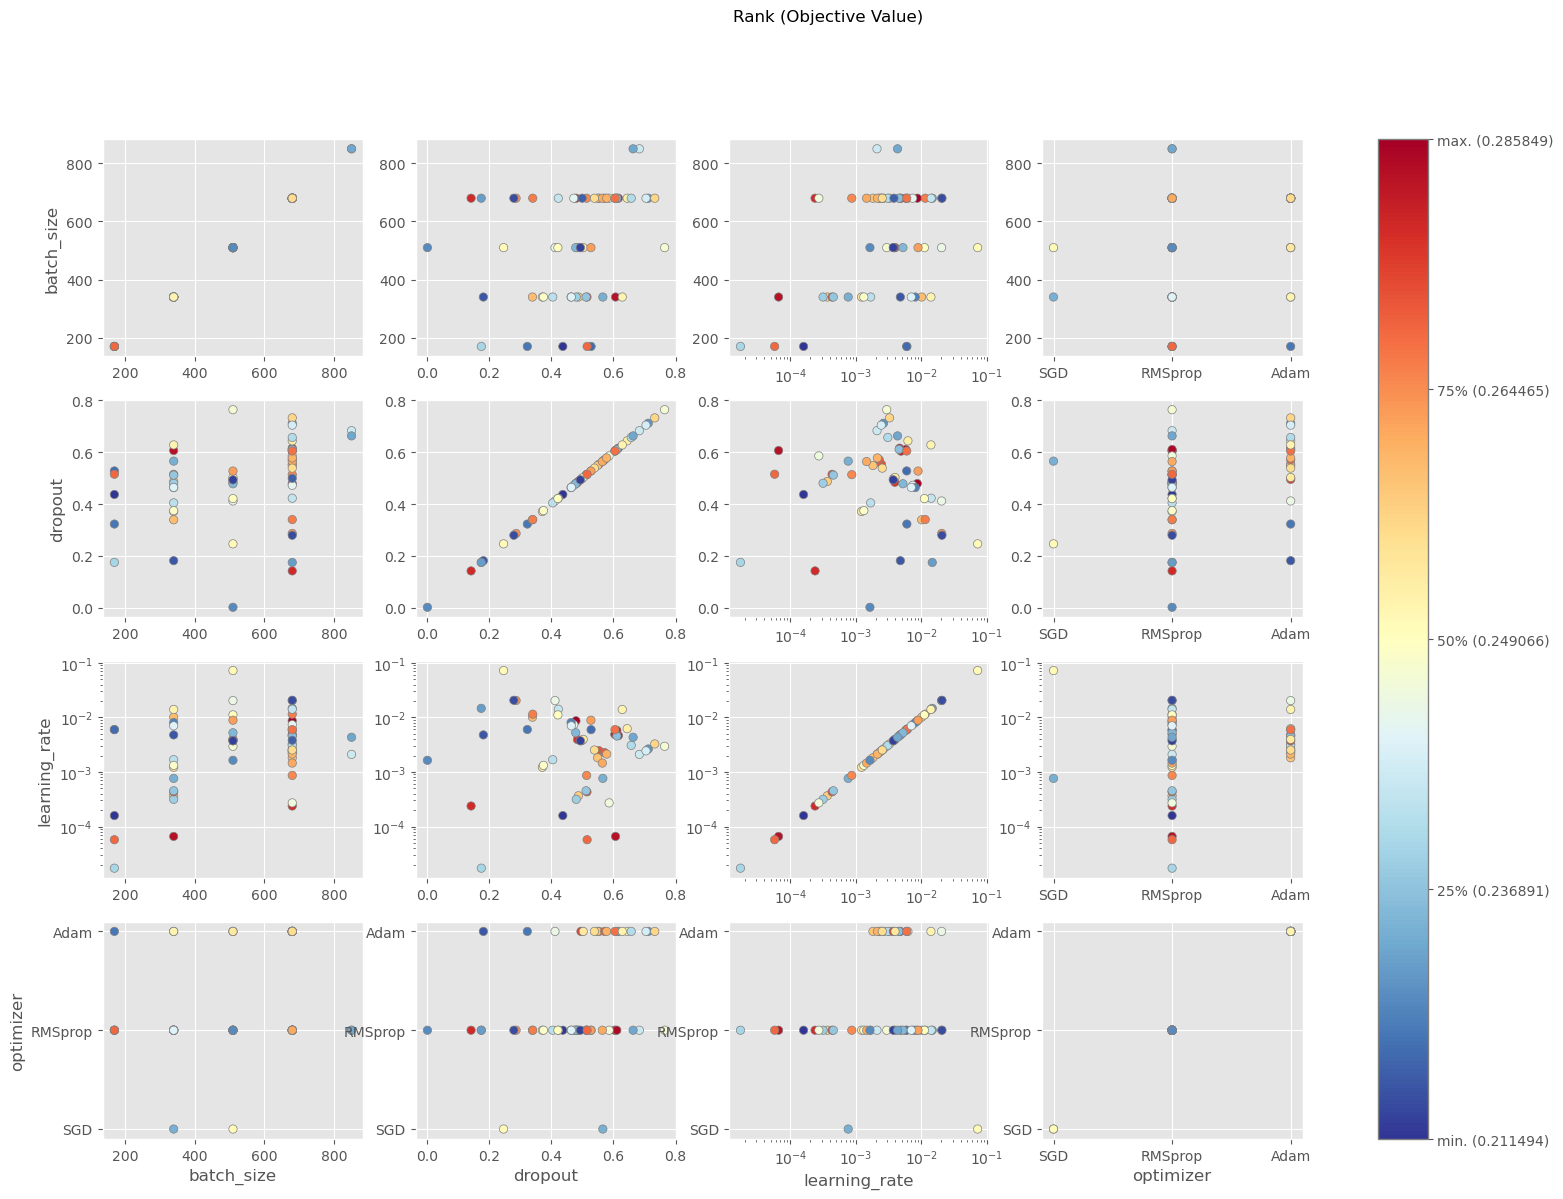

In [55]:
# Visualize parameter relations with scatter plots colored by objective values.
plot_rank(study)
set_size(15, 10)

/tmp/ipykernel_190012/124343896.py:2: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  plot_timeline(study)


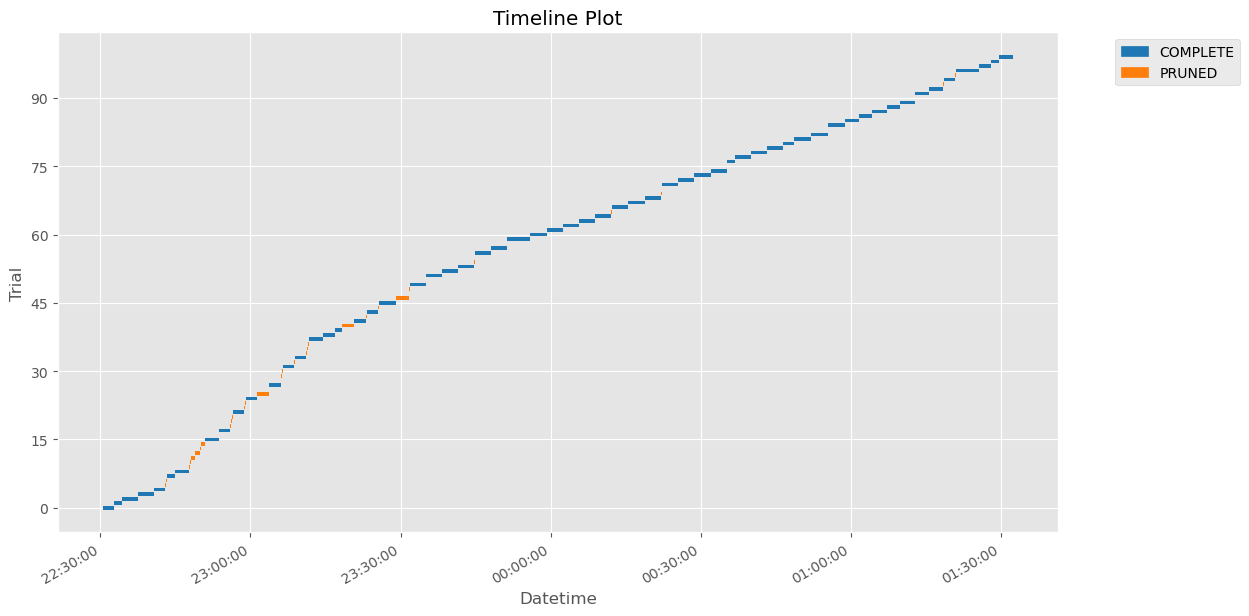

In [56]:
# Visualize the optimization timeline of performed trials.
plot_timeline(study)
set_size(10, 5)